## Bomb radiocarbon inventory calculation (CCSM 3.0, ECCOv4 ECCO_old and UVic)
We want to quantify radiocarbon fluxes both before and after bias correction, in particular the **bomb-produced** fluxes, in order to quantify bomb radiocarbon inventory.

Credits to Dr. Heather Graven for the below information -------------------------

**For each grid cell:**

Net air-sea flux is the balance between gross **air-sea** and **sea-air** fluxes, i.e. net air-sea flux = (**air-sea** flux $F_{as}$) - (**sea-air** flux $F_{sa}$). These fluxes are read as ```FG_CO2_abio_as``` and ```FG_CO2_abio_sa``` respectively.

The net flux of $^{14}C$ is thus

$$ \text{Net } ^{14}C \text{ flux} = \left[F_{as} \left(\frac{\Delta ^{14} C_a}{1000} + 1\right) - F_{sa} \left(\frac{\Delta ^{14} C_s}{1000} + 1\right)\right] \times \text{standard ratio},$$

where $\Delta ^{14} C_a$ and $\Delta ^{14} C_s$ correspond to $\Delta ^{14}C$ in the atmosphere and sea respectively, and the standard ratio of $^{14}C/C = 1.170 \times 10^{-12}$.

The atmospheric values of $\Delta ^{14}C$ are read from the file ```TableS1_170717.xlsx```. We need to separate according to year and latitude bands ($90^\circ$S to $30^\circ$S, $30^\circ$S to $30^\circ$N, and $30^\circ$N to $90^\circ$N).

The sea values are simply calculated from the simulated data in the CCSM model, separated into grid cells and year.

We assume that bomb radiocarbon flux was zero in 1950, when the nuclear tests just started. Therefore to evaluate the bomb radiocarbon flux, we subtract the total net flux in each year by the value in 1950 (reference point).

**Combine for bomb radiocarbon inventory:**

Repeating the above for each grid cell, then we can calculate **cumulative annual sums** of the fluxes over all grid cells by **multiplying by grid cell area**, cumulative between 1950 and the year of interest.

Assuming the bomb radiocarbon inventory was zero in 1950, the cumulative annual sum for each year is equivalent to the bomb radiocarbon inventory of that year.

Radiocarbon inventory is measured in units of $10^{26}$ atoms.

In [1]:
### if packages do not load install them using 
### conda install package-name
### or
### pip install package-name
import numpy as np
import scipy
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd

In [2]:
plt.rcParams.update({'font.size': 12})

## CCSM 3.0
### 1. Prepare relevant data
Import atmospheric $\Delta ^{14}C$ data, from file ```TableS1_170717.xlsx``` converted to CSV format.

In [4]:
D14C_atm = pd.read_csv('/home/kty115/msci/Model/RC_Inventory/TableS1_170717.csv', sep=',').drop(columns=["Date"])

In [5]:
D14C_atm.head()

,Year,NH_D14co2_(per mil),Tropics_D14co2_(per mil),SH_D14co2_(per mil),Global_D13co2_(per mil)
0,1850,-2.3,-4.0,-5.8,-6.61
1,1851,-2.6,-4.3,-6.0,-6.61
2,1852,-2.9,-4.6,-6.2,-6.61
3,1853,-3.2,-4.8,-6.4,-6.61
4,1854,-3.5,-5.1,-6.6,-6.62


In [4]:
### read in netcdf file for different runs, here for the historic simulation
file_ccsm_hist=netCDF4.Dataset('/rds/general/project/nowack_graven/live/msci18/ccsm_hist/ETHZ_L1_51.1a_Anth.pop.h.1950_2012.nc','r')
file_ccsm_spin=netCDF4.Dataset('/rds/general/project/nowack_graven/live/msci18/ccsm_spinup/spin_up_all_years.nc','r')

In [7]:
### extract 'Abiotic Dissolved Inorganic Carbon both 12C and C14
aDIC_hist=file_ccsm_hist.variables['aDIC'][:,:,:,:]
aDIC14_hist=file_ccsm_hist.variables['aDIC14'][:,:,:,:]

In [8]:
### This is D14C_sea
D14C_hist=(aDIC14_hist/aDIC_hist-1)*1000

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/numpy/ma/core.py:1016: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [9]:
lat_, lon_ = np.where((D14C_hist[20,0,:,:] > 275) &  (D14C_hist[20,0,:,:] < 10**5))
for (lat_ind,lon_ind) in zip(lat_, lon_):
    D14C_hist[:,:,lat_ind,lon_ind] = 9.9692100e+36
    D14C_hist[:,:,lat_ind,lon_ind] = np.ma.masked 

In [5]:
### read gross air-sea and sea-air fluxes from file
airseaf = file_ccsm_hist.variables['FG_CO2_abio_as'][:,:,:]
seaairf = file_ccsm_hist.variables['FG_CO2_abio_sa'][:,:,:]

In [11]:
#Grid centres - needed to find lat of each grid to match to correponding atm D14C
lon_gridc=file_ccsm_hist.variables['TLONG'][:]
lat_gridc=file_ccsm_hist.variables['TLAT'][:]

### 2. Calculate net $^{14}C$ flux for each grid

In [15]:
net14C_flux = np.ma.empty_like(D14C_hist[:,0,:,:]) # Extract surface layer

for yr_ind in range(D14C_hist.shape[0]):
    for lat_ind in range(D14C_hist.shape[2]):
        for lon_ind in range(D14C_hist.shape[3]):
            if np.ma.is_masked(D14C_hist[yr_ind, 0, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (D14C_hist[yr_ind, 0, lat_ind, lon_ind]/1000+1)) * 1.17e-12

### 3. Combine to form radiocarbon inventory for each year

Now we subtract the net flux of each year from the 1950 values to obtain the bomb contribution to the net flux.

In [12]:
bomb14C_flux = np.ma.empty_like(net14C_flux)

bomb14C_flux[:,:,:] = net14C_flux[:,:,:] - net14C_flux[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [13]:
cum_bomb14C_flux = np.ma.empty_like(bomb14C_flux)

for i in range(1, cum_bomb14C_flux.shape[0]):
    cum_bomb14C_flux[i,:,:] = cum_bomb14C_flux[i-1 ,:,:] + bomb14C_flux[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

Sum over all grid cells (weighted by grid cell areas) to obtain inventory for each year:

We will need a weighted sum of the fluxes, weighted according to the area of the grid cell.

In [9]:
domain = netCDF4.Dataset("/home/kty115/msci/Model/CCSM_ECCOv4/domain.nc")
cell_area = domain.variables["area"][:,:]
cell_area *= (6371e3)**2

In [10]:
cell_area.dump("cell_area")

In [45]:
cell_area.shape

(116, 100)

In [14]:
cell_area[58]

masked_array(data=[0.00087414, 0.00087424, 0.00087446, 0.00087478,
                   0.0008752 , 0.00087573, 0.00087636, 0.00087708,
                   0.0008779 , 0.00087882, 0.00087982, 0.0008809 ,
                   0.00088207, 0.00088331, 0.00088463, 0.00088601,
                   0.00088744, 0.00088894, 0.00089048, 0.00089206,
                   0.00089368, 0.00089534, 0.00089701, 0.0008987 ,
                   0.0009004 , 0.0009021 , 0.0009038 , 0.00090549,
                   0.00090717, 0.00090882, 0.00091044, 0.00091202,
                   0.00091356, 0.00091506, 0.00091649, 0.00091787,
                   0.00091919, 0.00092043, 0.00092159, 0.00092268,
                   0.00092368, 0.00092459, 0.00092541, 0.00092614,
                   0.00092676, 0.00092729, 0.00092771, 0.00092803,
                   0.00092825, 0.00092835, 0.00092835, 0.00092825,
                   0.00092803, 0.00092771, 0.00092729, 0.00092676,
                   0.00092614, 0.00092541, 0.00092459, 0.00092

So we assume that each value correspond to the grid at location as described by ```lat_gridc``` and ```lon_gridc``` with the same indices.

We need to know our current units:

In [16]:
print(file_ccsm_hist.variables['FG_CO2_abio_as'])

<class 'netCDF4._netCDF4.Variable'>
float32 FG_CO2_abio_as(time, nlat, nlon)
    long_name: air-to-sea abio CO2 Flux
    units: mmol DIC/m^3 cm/sec
    coordinates: TLAT TLONG
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
    cell_methods: time: mean
unlimited dimensions: time
current shape = (63, 116, 100)
filling on


Visualise the time series of the fluxes at a certain grid point:

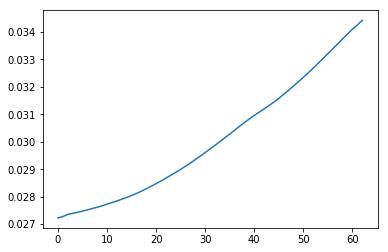

In [8]:
plt.figure()
plt.plot(np.arange(63), airseaf[:,58,50])

These have units of mmol DIC/m$^3$ cm/s.

In [43]:
print(domain.variables["area"])

<class 'netCDF4._netCDF4.Variable'>
float64 area(nj, ni)
    long_name: area of grid cell in radians squared
    units: area
unlimited dimensions: 
current shape = (116, 100)
filling on, default _FillValue of 9.969209968386869e+36 used



Area has units radians squared. It is common when treating spherical systems like the Earth, to express lengths (and hence areas) in terms of angular units. On each dimension 1 and 2, an arc of arc length $s_{1,2}$ subtends an angle $\theta_{1,2}$ at the centre of the Earth, so $s = r\theta$, where $r$ is the radius of the Earth. Since area is (approximately when small) $s_1 s_2 = r^2 \theta_1 \theta_2$, so we simply multiply the radians squared angle by $r^2$ to get units of m$^2$.

In [232]:
cell_area[58,50]

37681554832.34602

In [15]:
inv = np.zeros(cum_bomb14C_flux.shape[0])

for i in range(len(inv)):
    inv[i] = np.sum(cum_bomb14C_flux[i,:,:]*cell_area[:,:])

In [16]:
inv

array([0.00000000e+00, 5.52961042e+05, 1.76720951e+06, 3.76550637e+06,
       7.55775625e+06, 1.84193514e+07, 4.57120212e+07, 8.85300902e+07,
       1.60873724e+08, 2.71644783e+08, 3.92870484e+08, 5.15523157e+08,
       6.64707237e+08, 9.26689980e+08, 1.28463691e+09, 1.65588531e+09,
       1.99599374e+09, 2.29964209e+09, 2.57170553e+09, 2.82789641e+09,
       3.06955574e+09, 3.29565346e+09, 3.50259338e+09, 3.68590706e+09,
       3.85224147e+09, 4.00592338e+09, 4.14484549e+09, 4.27017821e+09,
       4.38899750e+09, 4.49377388e+09, 4.58552232e+09, 4.66888436e+09,
       4.74414155e+09, 4.81080265e+09, 4.87031294e+09, 4.92714764e+09,
       4.97951688e+09, 5.02786493e+09, 5.07405849e+09, 5.11408886e+09,
       5.14907155e+09, 5.18016338e+09, 5.20778598e+09, 5.23341350e+09,
       5.25656952e+09, 5.27792801e+09, 5.29784369e+09, 5.31487460e+09,
       5.33094546e+09, 5.34519858e+09, 5.35701629e+09, 5.36675215e+09,
       5.37464952e+09, 5.38110773e+09, 5.38514522e+09, 5.38808943e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [17]:
inv_f = inv*10**-2*6.02e23*1e-3/1e26

### 4. Find new inventory using bias corrected values
#### 4.1 Load comparison file between observation and model

In [15]:
# REAL ONES FOR INVENTORY
D14C_comp_real = pd.read_csv('/home/kty115/msci/Model/ECCOold_CCSM_test/ObsCCSM_new2.csv')
D14C_comp_real.tail()

,Unnamed: 0,index,year_round,lat_round2,lon_round2,depth,D14C,associated_lat,associated_lon,CCSM_value
3819,3819,4951,2012,35.71,292.83,2.878900,67.700000,35.472813,291.424744,69.621918
3820,3820,4952,2012,37.25,307.67,2.977700,53.300000,37.102856,309.176117,62.134148
3821,3821,4953,2012,37.81,291.53,22.529033,68.633333,37.665703,291.565002,63.977005
3822,3822,4954,2012,40.40,307.67,3.572300,50.700000,40.986431,309.317291,42.015671
3823,3823,4955,2012,42.05,308.42,2.976400,57.700000,42.752262,309.401093,33.912422


In [16]:
D14C_comp_real_unique = D14C_comp_real.groupby(['year_round','associated_lat','associated_lon']).mean().reset_index() #Remove duplicates that may have been generated from the regridding procedure

In [17]:
D14C_comp_real_unique = D14C_comp_real_unique.drop(['depth', 'lat_round2', 'lon_round2', 'Unnamed: 0'], axis=1)
D14C_comp_real_unique.columns = ['year_round', 'mod_lat','mod_lon', "index", "D14C", "mod_D14C"] #where D14C is the real observation value 

#### 4.2 Plot real biases

In [13]:
# Save into CSV
prop_map_vis_ft_ccsm = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Fuzz_Time/Fuzz_clmap.csv", delimiter=",")
prop_map_ft_ccsm = np.zeros([prop_map_vis_ft_ccsm.shape[0], prop_map_vis_ft_ccsm.shape[1], 10])
for i in range(prop_map_ft_ccsm.shape[2]):
    prop_map_ft_ccsm[:,:,i] = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Fuzz_Time/Fuzz_umat_cl{0}.csv".format(i), delimiter=",")

In [10]:
# Save into CSV
prop_map_vis_ff_ccsm = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Fuzz_Feat/FuzzF_clmap.csv", delimiter=",")
prop_map_ff_ccsm = np.zeros([prop_map_vis_ff_ccsm.shape[0], prop_map_vis_ff_ccsm.shape[1], 10])
for i in range(prop_map_ff_ccsm.shape[2]):
    prop_map_ff_ccsm[:,:,i] = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Fuzz_Feat/FuzzF_umat_cl{0}.csv".format(i), delimiter=",")

In [92]:
# Save into CSV
prop_map_ht_ccsm = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Hard_Time/Hard_clmap.csv", delimiter=",")
prop_map_hf_ccsm = np.loadtxt("/home/kty115/msci/Model/CCSM_ECCOv4/Hard_Feat/HardF_clmap.csv", delimiter=",")

In [12]:
# Credits : Gerald --------------------------------------
def plot_bias1(cl_map, D14C_fobsv, D14C_inp=D14C_hist, lat_grid_inp=lat_gridc, lon_grid_inp=lon_gridc, plot=True, mod_name="CCSM"):
    ''' 
    Plots biases of each cluster.
    Inputs:
    -------
    cl_map: lat x lon array of each grid cell's assigned clusters 
    D14C_fobsv: Dataframe of D14C observations (1 per lat/lon/year) from 1960-2013
    D14C_inp: Values of D14C in model
    lat_grid_inp: Latitude grid (2D) of model
    lon_grid_inp: Longitude grid (2D) of model
    plot: whether to plot the resulting bias
    mod_name: name of model
    
    Outputs:
    --------
    Plot of all available biases (with both observation and data not masked) for each cluster for each hemisphere.
    time : year of each bias point, separated into each hemisphere (axis 0) and each cluster (axis 1)
    D14C_obs : observed D14C values, separated into each hemisphere (axis 0) and each cluster (axis 1)
    D14C_mod : model D14C values, separated into each hemisphere (axis 0) and each cluster (axis 1)
    '''
    # D14C_obs for observation and D14C_mod for model
    time = [[] for x in range(int(np.max(cl_map))+1)]
    D14C_obs = [[] for x in range(int(np.max(cl_map))+1)] #Observations
    D14C_mod = [[] for x in range(int(np.max(cl_map))+1)] #ECCO Model data for cells corresponding to those with observations
    
    mod_lon = np.array(D14C_fobsv['mod_lon'])
    mod_lat = np.array(D14C_fobsv['mod_lat']) #lat (in CCSM grid) of real observation
    mod_D14C = np.array(D14C_fobsv['D14C'])  #real observation
    
    indx = 0
    
    for (lat, lon) in zip(mod_lat, mod_lon):
        # Cluster num for each associated lat and lon
        lat_ind, lon_ind = np.where((abs(lat_grid_inp - lat) < 1e-2) & (abs(lon_grid_inp - lon) < 1e-2))
        if len(lat_ind) > 1 or len(lon_ind) > 1:
            for dupe_ind in range(1, len(lat_ind)):  # Test if all cells found have identical D14C values over all years -> duplicates
                if all(D14C_inp[:,0,lat_ind[dupe_ind],lon_ind[dupe_ind]] == D14C_inp[:,0,lat_ind[0], lon_ind[0]]):  # If everything identical to first grid cell found
                    pass  # Just use first grid cell found
                else:
                    raise Exception("More than 1 cell found, with different D14C values.")
        if type(cl_map[lat_ind[0], lon_ind[0]]) == np.float64:
            c_num = int(cl_map[lat_ind[0], lon_ind[0]])
            time[c_num].append(list(D14C_fobsv['year_round'])[indx])
            D14C_obs[c_num].append(list(D14C_fobsv['D14C'])[indx])
            D14C_mod[c_num].append(D14C_inp[list(D14C_fobsv['year_round'])[indx]-1950,0,lat_ind[0],lon_ind[0]])
                
        else:
            pass
        indx += 1
    
    D14C_bias = [0]*(int(np.max(cl_map))+1) # stores the bias (mod - obs)
    
    if plot:
        fig, ax = plt.subplots(int(np.max(cl_map))+1, 1, figsize = (6, 3*(int(np.max(cl_map))+1)))
        for i in range(int(np.max(cl_map))+1):
            #Set up and label subplot axes
            ax[i].set_xlabel("Year")
            ax[i].set_ylabel(r"$\Delta ^{14}$C biases")
            ax[i].set_title(f"Bias in cluster {i+1}")

            ax[i].plot(time[i], np.array(D14C_mod[i]) - np.array(D14C_obs[i]), 'gx', label = f'{mod_name} - Observations')

            # Draw a line at zero to show more clearly which direction the biases are in
            ax[i].plot(np.array([1948, 2015]), np.array([0,0]), 'k--')

            # Set xticks and xlim to fit year limit (1960 - 2013) for better comparison
            ax[i].set_xticks(np.arange(1950, 2015, 10))
            ax[i].set_xlim((1948, 2015))
            ax[i].legend()

            fig.tight_layout()    
    
    for i in range(int(np.max(cl_map))+1):
        # Change the list in each cluster into an array
        # (we can't change the whole thing because the array for each cluster is of a different length, so cannot be combined into a large np array (which works like a matrix))
        time[i] = np.array(time[i])
        D14C_obs[i] = np.array(D14C_obs[i])
        D14C_mod[i] = np.array(D14C_mod[i])
        D14C_bias[i] = D14C_mod[i] - D14C_obs[i]
    return time, D14C_bias

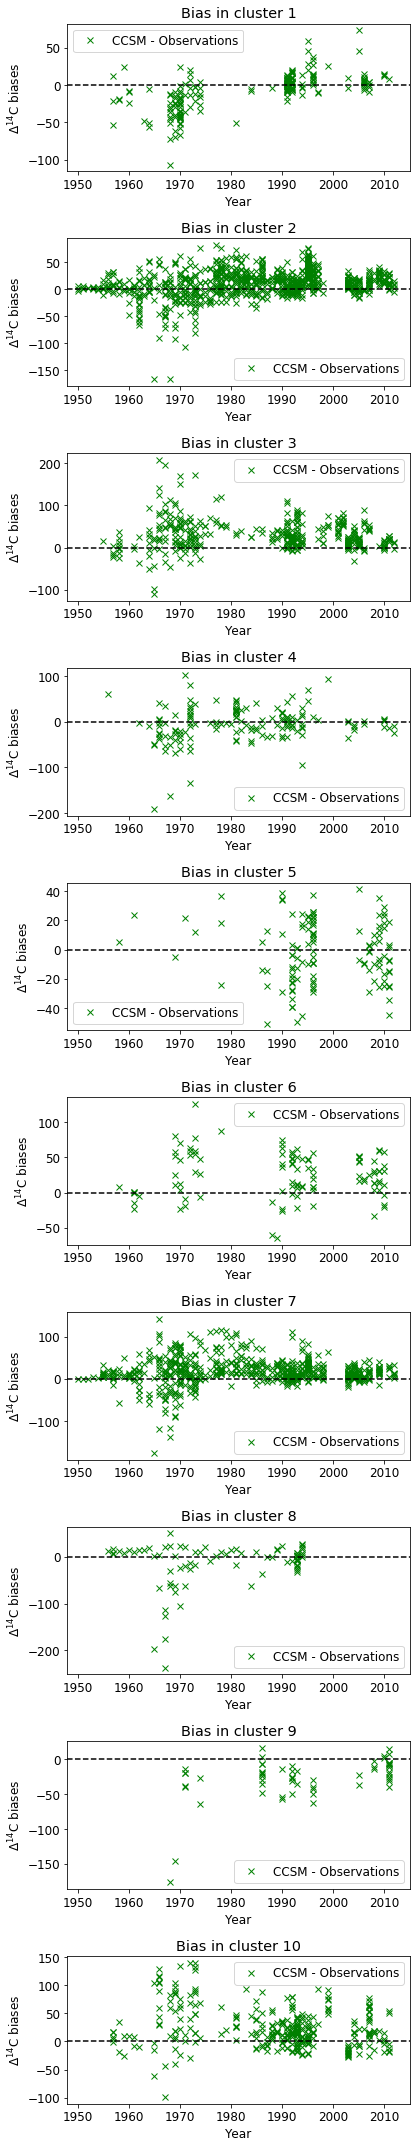

In [18]:
time_ccsm_ft, bias_ccsm_ft = plot_bias1(prop_map_vis_ft_ccsm, D14C_comp_real_unique)

In [16]:
time_ccsm_ff, bias_ccsm_ff = plot_bias1(prop_map_vis_ff_ccsm, D14C_comp_real_unique, plot=False)

In [100]:
time_ccsm_ht, bias_ccsm_ht = plot_bias1(prop_map_ht_ccsm, D14C_comp_real_unique, plot=False)

In [101]:
time_ccsm_hf, bias_ccsm_hf = plot_bias1(prop_map_hf_ccsm, D14C_comp_real_unique, plot=False)

#### 4.3 Fit according to automated algorithm

In [19]:
def autobiascorrect_h(yr_st, yr_end, D14C_data, year_data, bias_data, cl_map, yr_obs_st=None, plot=True, mod_name="CCSM"):
    """
    Plots data points (xdata, ydata) together with a fitted line, using different thresholds for the transition between methods (average, quad),
    based on number of observations as derived using different pairs of models.
    
    Inputs:
    -------
    yr_st, yr_end : start and end years of MODEL data
    year_data, bias_data : read x and y-values from (requires x-values (Year) sorted in ascending order).
    cl_map : Map of which cluster each grid cell belong to.
    yr_obs_st: start year of OBSERVAITONAL data (if different from MODEL).
    plot : whether to plot the line for all clusters and return the parameters used in fitting (True) or just return the parameters (False). Default True.
    
    Output:
    -------
    Plots of selected data points with fitted curves.
    """
    if yr_obs_st is None:
        yr_obs_st = yr_st
        
    # Number of clusters to plot
    num_clstr_plot = len(year_data)
    if plot:
        fig, ax = plt.subplots(num_clstr_plot, 1, figsize = (6, 3*num_clstr_plot))
    
    # Stores all parameters
    param = np.zeros([num_clstr_plot, 3])
    # Find fit degree for each cluster
    fitdeg = np.zeros([num_clstr_plot], dtype=int)
    
    no_obs = []
    
    for i in range(num_clstr_plot):
        # Find number of points in each cluster
        no_obs.append(len(year_data[i]))

        if len(year_data[i]) > 0: # something in the cluster to fit
            if no_obs[i] <= 267:  # From eyeballing existing data
                # Average fit
                param[i, -1] = np.average(bias_data[i])
                fitdeg[i] = 0
            else:
                # Quad fit
                param[i, -3:] = np.polyfit(year_data[i], bias_data[i], 2)
                fitdeg[i] = 2
                
    # Find RMSE - Bias correct ### Credits : Gerald
    new_data = np.zeros_like(D14C_data)
    correction = np.zeros_like(D14C_data[:,0,:,:])   
  
    for i in range(num_clstr_plot): #loop thru clusters
        lat_ind, lon_ind = np.where(cl_map == i)
        for yr in range(yr_obs_st-yr_st, yr_end-yr_st+1):  # yr_obs_st-yr_st to account for start of observation after
            for (lt, ln) in zip(lat_ind, lon_ind):
                for dg in range(fitdeg[i]+1):
                    correction[yr, lt, ln] += param[i, -dg-1]*((yr+yr_st)**(dg))
                
    new_data[yr_obs_st-yr_st:,0,:,:] = D14C_data[yr_obs_st-yr_st:,0,:,:] - correction[yr_obs_st-yr_st:,:,:]
    
    print(fitdeg)
    if plot:
        for i in range(num_clstr_plot):
            # Plot optimised configuration
            # Fit a number of points for plotting
            linfit = []
            fitrange = np.arange(yr_st - 2, yr_end + 2)
            for xpt in fitrange:
                val = 0
                for power in range(fitdeg[i] + 1):
                    val += param[i, -1-power]*(xpt**power) # Highest power first
                linfit.append(val)
            # Plot the result
            ax[i].plot(fitrange, linfit, 'r-.', label="Order {0} polynomial fit".format(fitdeg[i]))
            ax[i].set_title(f"Order {fitdeg[i]} fit, cluster {i+1}")

            ax[i].set_xlabel("Year")
            ax[i].set_ylabel(r"$\Delta ^{14}$C Bias")
            ax[i].plot(year_data[i], bias_data[i], 'gx', label=f"{mod_name} - Observations")
            ax[i].plot([yr_st-2, yr_end+2], [0,0], 'k--')
            # Set xticks and xlim to fit year limit for better comparison
            ax[i].set_xticks(np.arange(yr_st-5, yr_end+5, 10))
            ax[i].set_xlim((yr_st-2, yr_end+2))
            ax[i].legend()

            fig.tight_layout()
    return fitdeg, new_data

In [20]:
def autobiascorrect_f(yr_st, yr_end, D14C_data, year_data, bias_data, cl_map, cl_map_u, yr_obs_st=None, plot=True, mod_name="CCSM"):
    """
    Plots data points (xdata, ydata) together with a fitted line, using different thresholds for the transition between methods (average, quad),
    based on number of observations as derived using different pairs of models.
    
    Inputs:
    -------
    yr_st, yr_end : start and end years of MODEL data
    year_data, bias_data : read x and y-values from (requires x-values (Year) sorted in ascending order).
    cl_map : Map of which cluster each grid cell belong to.
    cl_map_u : C-partition matrix which stores the similarity score of each grid cell to every cluster.
    yr_obs_st: start year of OBSERVAITONAL data (if different from MODEL).
    plot : whether to plot the line for all clusters and return the parameters used in fitting (True) or just return the parameters (False). Default True.
    
    Output:
    -------
    Plots of selected data points with fitted curves.
    """
    if yr_obs_st is None:
        yr_obs_st = yr_st
        
    # Number of clusters to plot
    num_clstr_plot = len(year_data)
    if plot:
        fig, ax = plt.subplots(num_clstr_plot, 1, figsize = (6, 3*num_clstr_plot))
    
    # Stores all parameters
    param = np.zeros([num_clstr_plot, 3])
    # Find fit degree for each cluster
    fitdeg = np.zeros([num_clstr_plot], dtype=int)
    
    no_obs = []
    
    for i in range(num_clstr_plot):
        # Find number of points in each cluster
        no_obs.append(len(year_data[i]))

        if len(year_data[i]) > 0: # something in the cluster to fit
            if no_obs[i] <= 267:  # From eyeballing existing data
                # Average fit
                param[i, -1] = np.average(bias_data[i])
                fitdeg[i] = 0
            else:
                # Quad fit
                param[i, -3:] = np.polyfit(year_data[i], bias_data[i], 2)
                fitdeg[i] = 2
                
    # Find RMSE - Bias correct ### Credits : Gerald
    new_data = np.zeros_like(D14C_data)
    correction = np.zeros_like(D14C_data[:,0,:,:])   

    for i in range(num_clstr_plot): #loop thru clusters
        for yr in range(yr_obs_st-yr_st, yr_end-yr_st+1):  # yr_obs_st-yr_st to account for start of observation after 
            #lat_ind, lon_ind = np.where(cl_map == i)
            for dg in range(fitdeg[i]+1):
                correction[yr, :, :] += param[i, -dg-1]*((yr+yr_st)**(dg))*cl_map_u[:,:,i]  # Polyfit multplied by fuzzyness coefficient
                
    new_data[yr_obs_st-yr_st:,0,:,:] = D14C_data[yr_obs_st-yr_st:,0,:,:] - correction[yr_obs_st-yr_st:,:,:]
    
    print(fitdeg)
    if plot:
        for i in range(num_clstr_plot):
            # Plot optimised configuration
            # Fit a number of points for plotting
            linfit = []
            fitrange = np.arange(yr_st - 2, yr_end + 2)
            for xpt in fitrange:
                val = 0
                for power in range(fitdeg[i] + 1):
                    val += param[i, -1-power]*(xpt**power) # Highest power first
                linfit.append(val)
            # Plot the result
            ax[i].plot(fitrange, linfit, 'r-.', label="Order {0} polynomial fit".format(fitdeg[i]))
            ax[i].set_title(f"Order {fitdeg[i]} fit, cluster {i+1}")

            ax[i].set_xlabel("Year")
            ax[i].set_ylabel(r"$\Delta ^{14}$C Bias")
            ax[i].plot(year_data[i], bias_data[i], 'gx', label=f"{mod_name} - Observations")
            ax[i].plot([yr_st-2, yr_end+2], [0,0], 'k--')
            # Set xticks and xlim to fit year limit for better comparison
            ax[i].set_xticks(np.arange(yr_st, yr_end+10, 10))
            ax[i].set_xlim((yr_st-2, yr_end+2))
            ax[i].legend()

            fig.tight_layout()
    return fitdeg, new_data

[0 2 2 0 0 0 2 0 0 2]


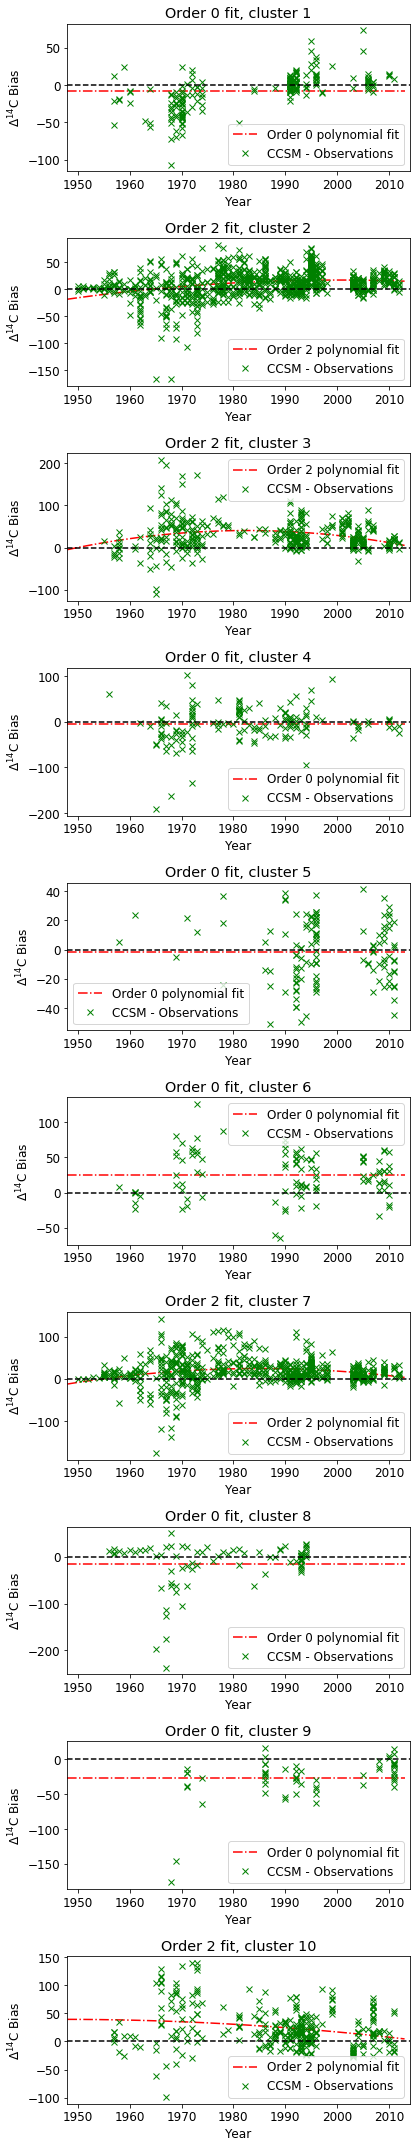

In [21]:
fitdeg_f, D14C_hist_new = autobiascorrect_f(1950, 2012, D14C_hist, time_ccsm_ft, bias_ccsm_ft, prop_map_vis_ft_ccsm, prop_map_ft_ccsm)

In [48]:
fitdeg_f, D14C_hist_new = autobiascorrect_f(1950, 2012, D14C_hist, time_ccsm_ff, bias_ccsm_ff, prop_map_vis_ff_ccsm, prop_map_ff_ccsm, plot=False)

[2 2 2 2 0 0 2 0 0 0]


In [120]:
fitdeg_f, D14C_hist_new = autobiascorrect_h(1950, 2012, D14C_hist, time_ccsm_hf, bias_ccsm_hf, prop_map_hf_ccsm, plot=False)

[2 0 2 0 2 2 0 0 0 0]


In [127]:
fitdeg_f, D14C_hist_new = autobiascorrect_h(1950, 2012, D14C_hist, time_ccsm_ht, bias_ccsm_ht, prop_map_ht_ccsm, plot=False)

[2 0 2 0 2 2 0 0 0 2]


In [47]:
# Save new D14C distribution into CSV file
for yr in range(D14C_hist_new.shape[0]):
    np.savetxt(f"/home/kty115/msci/Model/RC_Inventory/InterpCCSM/D14C_new_CCSM_ht/D14C_new_{yr+1950}_CCSM_ht.csv", D14C_hist_new[yr,0,:,:], delimiter=",")

### Save into obs_mod_file CSV

In [18]:
# Credits : Gerald ------------------------------------------------------------
def obs_mod_file_new(D14C_robsv, D14C_hist_n, lat_grid_mod, lon_grid_mod):
    '''
    Creates a dataframe of D14C observations and their corresponding model lat/lon and D14C values and saves them to a csv file.
    
    Input:
    ------
    D14C_robsv: pandas.core.frame.DataFrame
        Dataframe of D14C observations (1 per lat/lon/year)
    D14C_hist_n: new D14C maps (in dim year:)
        
    Output:
    -------
    mod_lat : associated model latitudes
    mod_lon : associated model longitudes
    mod_D14C : model D14C values at each mod_lat, mod_lon
    '''
    # For each observation identify its corresponding grid cell equivalent
    mod_lat = []
    mod_lon = []
    mod_lat_ind = []
    mod_lon_ind = []
    #For each observation (lat,lon), loop through the lat,lon grid coordinates and pick out the grid with the smallest euclidean distance between them 
    for lat, lon in zip(D14C_robsv['lat_round2'], D14C_robsv['lon_round2']):
        obs = np.array([lat, lon])
        dist = 1e4 #Just some initial large distance number to compare
        as_lat = 0
        as_lon = 0
        as_lat_ind = 0
        as_lon_ind = 0
        
        # Choose all points within 2 degrees of lat and lon of the observation
        pos_lat,pos_lon = np.where((lat_grid_mod >= lat-2) & (lat_grid_mod <= lat+2) & (lon_grid_mod >= lon-2) & (lon_grid_mod <= lon+2))  #some tolerance level to speed up the calc

        for i,j in zip(pos_lat, pos_lon):
            mod = np.array([lat_grid_mod[i][j], lon_grid_mod[i][j]])
            # Normed distance between observation and model grid point
            dic = np.linalg.norm(obs-mod)
            if dic < dist:
                dist = dic
                as_lat = lat_grid_mod[i][j]
                as_lon = lon_grid_mod[i][j]
                as_lat_ind = i
                as_lon_ind = j
        
        mod_lat.append(as_lat)
        mod_lat_ind.append(as_lat_ind)
        mod_lon.append(as_lon)
        mod_lon_ind.append(as_lon_ind)
        
    mod_D14C = []
    indx = 0
    for (lat_ind, lon_ind) in zip(mod_lat_ind, mod_lon_ind):
        mod_D14C.append(D14C_hist_n[list(D14C_robsv['year_round'])[indx]-1950,0,lat_ind,lon_ind])
        indx  += 1
        
    #bias = np.array(mod_D14C) - np.array(D14C_robsv['D14C']) 
    return np.array(mod_lat), np.array(mod_lon), np.array(mod_D14C)

In [15]:
D14C_obsv = pd.read_csv('/home/kty115/msci/Observation/sfcD14Cave_new.csv').drop("Unnamed: 0", axis=1)
D14C_obsv.head()

,year_round,lat_round2,lon_round2,lat,lon,year,depth,D14C
0,1850,-70.65,168.07,-70.648,168.07,1850.0,25.0,-116.030
1,1850,-70.41,168.50,-70.411,168.50,1850.0,12.0,-113.180
2,1850,-69.93,169.34,-69.933,169.34,1850.0,11.0,-117.880
3,1850,-69.34,359.84,-69.342,359.84,1850.0,27.0,-112.020
4,1850,-68.87,272.02,-68.871,272.02,1850.0,23.0,-113.295


Select the data which correpond to the years in the CCSM model (1950 - 2012).

In [22]:
D14C_obsv_sel = D14C_obsv[D14C_obsv['year_round'].isin(np.arange(1950,2013))]

In [50]:
assoc_lat_new, assoc_lon_new, assoc_D14C_new = obs_mod_file_new(D14C_obsv_sel, D14C_hist_new, lat_gridc, lon_gridc)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Warning: converting a masked element to nan.


In [51]:
# Insert into existing DataFrame
D14C_obsv_asso_n = D14C_obsv_sel.copy()
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lat=assoc_lat_new)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lon=assoc_lon_new)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(CCSM_corr_value=assoc_D14C_new)  ### CHANGE TO CURRENT MODEL NAME

In [52]:
# Remove rows which does not have an associated lat / lon
import math
remove_rows = []
for i in range(len(D14C_obsv_asso_n.index)):
    if math.isnan(D14C_obsv_asso_n["CCSM_corr_value"].iloc[i]):
        remove_rows.append(i)
        
D14C_obsv_asso_nr = D14C_obsv_asso_n.reset_index().drop(remove_rows)

In [53]:
# Reset index, drop the old one since it's useless now
D14C_obsv_asso_nr = D14C_obsv_asso_nr.reset_index().drop(["level_0", "lat", "lon", "year"], axis=1)

In [55]:
D14C_obsv_asso_nr.to_csv("ObsCCSM_new_corr.csv")

### Calculate new inventory

In [128]:
net14C_flux_n = np.ma.empty_like(D14C_hist_new[:,0,:,:]) # Extract surface layer

for yr_ind in range(D14C_hist_new.shape[0]):
    for lat_ind in range(D14C_hist_new.shape[2]):
        for lon_ind in range(D14C_hist_new.shape[3]):
            if np.ma.is_masked(D14C_hist_new[yr_ind, 0, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_n[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (D14C_hist_new[yr_ind, 0, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [129]:
bomb14C_flux_n = np.ma.empty_like(net14C_flux_n)

bomb14C_flux_n[:,:,:] = net14C_flux_n[:,:,:] - net14C_flux_n[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [130]:
cum_bomb14C_flux_n = np.ma.empty_like(bomb14C_flux_n)

for i in range(1, cum_bomb14C_flux_n.shape[0]):
    cum_bomb14C_flux_n[i,:,:] = cum_bomb14C_flux_n[i-1 ,:,:] + bomb14C_flux_n[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [131]:
inv_n = np.zeros(cum_bomb14C_flux_n.shape[0])

for i in range(len(inv_n)):
    inv_n[i] = np.sum(cum_bomb14C_flux_n[i,:,:]*cell_area[:,:])

In [132]:
inv_n

array([0.00000000e+00, 1.23183454e+06, 3.78664767e+06, 7.76827608e+06,
       1.41709929e+07, 2.82550553e+07, 5.93643265e+07, 1.06578988e+08,
       1.83881714e+08, 3.00157588e+08, 4.27420360e+08, 5.56625640e+08,
       7.12861605e+08, 9.82380374e+08, 1.34832996e+09, 1.72803106e+09,
       2.07702840e+09, 2.38998519e+09, 2.67176196e+09, 2.93805527e+09,
       3.19019169e+09, 3.42712627e+09, 3.64524697e+09, 3.84006942e+09,
       4.01822442e+09, 4.18402290e+09, 4.33534145e+09, 4.47333252e+09,
       4.60505648e+09, 4.72296840e+09, 4.82806625e+09, 4.92497406e+09,
       5.01395683e+09, 5.09450431e+09, 5.16804585e+09, 5.23903593e+09,
       5.30566721e+09, 5.36836542e+09, 5.42897510e+09, 5.48346842e+09,
       5.53293941e+09, 5.57852028e+09, 5.62061118e+09, 5.66066680e+09,
       5.69818787e+09, 5.73383144e+09, 5.76793060e+09, 5.79902175e+09,
       5.82901201e+09, 5.85702105e+09, 5.88240837e+09, 5.90550779e+09,
       5.92653911e+09, 5.94587912e+09, 5.96252134e+09, 5.97776865e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [133]:
inv_f_n = inv_n*10**-2*6.02e23*1e-3/1e26

In [134]:
#np.savetxt("/home/kty115/msci/Model/CCSM_RCInv_ht.csv", inv_f, delimiter=",")
np.savetxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_ht.csv", inv_f_n, delimiter=",")

## ECCOv4
### 1. Prepare relevant data
Import NEW ECCOv4 data (1950 - 2013), with piston velocity 0.24. This matches with the one in CCSM.

In [22]:
import h5py
# Try new output data
f = h5py.File('/rds/general/project/nowack_graven/live/msci18/eccov4_hist_raw/piston_velocity_0p24/D14C_historical_rcp85_pv24.mat','r') 

file_ecco_hist = f.get('D14C_historical_rcp85_pv24_plot_ts')
file_ecco_hist = file_ecco_hist[1950-1765:2014-1765,:,:,:]  # Extract 1950 - 2012 data (to use CCSM fluxes)
file_ecco_hist = np.ma.masked_invalid(file_ecco_hist)

# Use f.get()[:] to get only the values of the variables as numpy arrays
lon_grid_ec = f.get('x')[:]
lat_grid_ec = np.ma.masked_invalid(f.get('y')[:])
lon_grid_ec.reshape(360*420)
dic = [x + 360 if x < 0 else x for x in lon_grid_ec.reshape(360*420)]
lon_grid_ec = np.ma.masked_invalid(np.array(dic).reshape(360,420))
depth = f.get('z')[:]
time = f.get('output_time')[:]
time_data = time[1]
time_data = time_data[1950-1765:2014-1765]  # Extract 1950 - 2012 data
f.close()

### 2. Interpolate to CCSM grid

In [11]:
# Credits : Gerald -------------------------------------------------------------------------------
def fake_obs_all(D14C_comp_ind, D14C_mod, D14C_fobs, fobs_name="ECCOv4", mod_name="CCSM"):
    equiv_unmk = np.zeros_like(D14C_mod[:,0,:,:])
    equiv_mk = D14C_mod[:,0,:,:].mask
    equiv = np.ma.array(equiv_unmk, mask=equiv_mk)  # change this according to the different start/end years of obs and mod
    for year in range(equiv.shape[0]):
        for latcs, loncs, latec, lonec in zip(D14C_comp_ind[f"{mod_name}_lat_ind"], D14C_comp_ind[f"{mod_name}_lon_ind"], D14C_comp_ind[f"{fobs_name}_lat_ind"], D14C_comp_ind[f"{fobs_name}_lon_ind"]):
            if latec == 0 and lonec == 0:  # Cannot find associated grid
                equiv[year, latcs, loncs] = np.ma.masked
            else:
                equiv[year, latcs, loncs] = D14C_fobs[year,0,latec,lonec]
    return equiv

In [12]:
D14C_compgrid_ind_CCSM_ECCOv4 = pd.read_csv("/home/kty115/msci/Model/CCSM_ECCOv4/D14C_CCSM_ECCOv4_gridinds.csv").drop("Unnamed: 0", axis=1)

In [16]:
fake_ecco_all = fake_obs_all(D14C_compgrid_ind_CCSM_ECCOv4, D14C_hist, file_ecco_hist)

In [17]:
fake_ecco_all.dump('ECCOv4_in_CCSM')

In [13]:
fake_ecco_all = np.load('ECCOv4_in_CCSM')

### 3. Combine to form radiocarbon inventory for each year

Now we subtract the net flux of each year from the 1950 values to obtain the bomb contribution to the net flux.

In [101]:
net14C_flux_ec = np.ma.array(np.zeros_like(fake_ecco_all[:,:,:]), mask=fake_ecco_all[:,:,:].mask) # Extract surface layer

for yr_ind in range(fake_ecco_all.shape[0]):
    for lat_ind in range(fake_ecco_all.shape[1]):
        for lon_ind in range(fake_ecco_all.shape[2]):
            if np.ma.is_masked(fake_ecco_all[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_ec[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_ecco_all[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [103]:
bomb14C_flux_ec = np.ma.zeros(net14C_flux_ec.shape)

bomb14C_flux_ec[:,:,:] = net14C_flux_ec[:,:,:] - net14C_flux_ec[0,:,:]  # Try subtracting from CCSM values in 1950

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [104]:
cum_bomb14C_flux_ec = np.ma.zeros(bomb14C_flux_ec.shape)

for i in range(1, cum_bomb14C_flux_ec.shape[0]):
    cum_bomb14C_flux_ec[i,:,:] = cum_bomb14C_flux_ec[i-1 ,:,:] + bomb14C_flux_ec[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [105]:
inv_ec = np.zeros(cum_bomb14C_flux_ec.shape[0])

for i in range(len(inv_ec)):
    inv_ec[i] = np.nansum(cum_bomb14C_flux_ec[i,:,:]*cell_area[:,:])

In [106]:
inv_ec

array([0.00000000e+00, 2.46031378e+05, 1.10112428e+06, 2.67660714e+06,
       5.99953168e+06, 1.70624942e+07, 4.57152862e+07, 9.12819080e+07,
       1.68142146e+08, 2.85465494e+08, 4.14882715e+08, 5.46765641e+08,
       7.08331747e+08, 9.91114857e+08, 1.37809697e+09, 1.78179045e+09,
       2.15427055e+09, 2.48984993e+09, 2.79326014e+09, 3.08036199e+09,
       3.35291924e+09, 3.60969231e+09, 3.84667009e+09, 4.05888116e+09,
       4.25287488e+09, 4.43347137e+09, 4.59882664e+09, 4.75037908e+09,
       4.89535482e+09, 5.02618214e+09, 5.14378533e+09, 5.25268039e+09,
       5.35279803e+09, 5.44311804e+09, 5.52511712e+09, 5.60368099e+09,
       5.67723715e+09, 5.74609900e+09, 5.81182473e+09, 5.87043969e+09,
       5.92321414e+09, 5.97135921e+09, 6.01537916e+09, 6.05681389e+09,
       6.09517463e+09, 6.13117238e+09, 6.16516375e+09, 6.19576682e+09,
       6.22497749e+09, 6.25193507e+09, 6.27597837e+09, 6.29743560e+09,
       6.31657278e+09, 6.33379279e+09, 6.34812185e+09, 6.36090678e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [107]:
inv_f_ec = inv_ec*10**-2*6.02e23*1e-3/1e26

### 4. Find new inventory using bias corrected values
#### 4.1 Load comparison file between observation and model

In [25]:
# REAL ONES FOR INVENTORY
D14C_comp_real_ec = pd.read_csv('/home/kty115/msci/Model/ECCOv4/ObsECCOv4_new_pv24.csv')
D14C_comp_real_ec.tail()

,Unnamed: 0,index,year_round,lat_round2,lon_round2,depth,D14C,associated_lat,associated_lon,ECCO_value
3894,3894,4989,2013,31.64,133.76,3.1778,52.8,31.833044,133.5,51.105581
3895,3895,4990,2013,31.88,133.58,28.0015,50.3,31.833044,133.5,51.105581
3896,3896,4991,2013,32.12,133.43,3.8728,55.7,31.833044,133.5,51.105581
3897,3897,4992,2013,32.31,240.85,3.8727,16.4,32.681243,240.5,26.103208
3898,3898,4993,2013,32.64,242.18,2.2838,3.4,32.681243,242.5,26.277693


In [26]:
D14C_comp_real_unique_ec = D14C_comp_real_ec.groupby(['year_round','associated_lat','associated_lon']).mean().reset_index() #Remove duplicates that may have been generated from the regridding procedure

In [27]:
D14C_comp_real_unique_ec = D14C_comp_real_unique_ec.drop(['depth', 'lat_round2', 'lon_round2', 'Unnamed: 0'], axis=1)
D14C_comp_real_unique_ec.columns = ['year_round', 'mod_lat','mod_lon', "index", "D14C", "mod_D14C"] #where D14C is the real observation value 

In [28]:
D14C_comp_real_unique_ec.tail()

,year_round,mod_lat,mod_lon,index,D14C,mod_D14C
3597,2013,30.976703,134.5,4987.0,61.400000,52.846690
3598,2013,30.976703,238.5,4988.0,18.600000,27.314093
3599,2013,31.833044,133.5,4990.0,52.933333,51.105581
3600,2013,32.681243,240.5,4992.0,16.400000,26.103208
3601,2013,32.681243,242.5,4993.0,3.400000,26.277693


#### 4.2 Plot real biases

In [19]:
# Save into CSV
prop_map_vis_ecco = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Fuzz_Time_ec/Fuzz_clmap_ec_pv24.csv", delimiter=",")
prop_map_ecco = np.zeros([prop_map_vis_ecco.shape[0], prop_map_vis_ecco.shape[1], 10])
for i in range(prop_map_ecco.shape[2]):
    prop_map_ecco[:,:,i] = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Fuzz_Time_ec/Fuzz_umat_cl{0}_ec_pv24.csv".format(i), delimiter=",")

In [19]:
# Save into CSV
prop_map_vis_ff_ecco = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Fuzz_Feat_ec/FuzzF_clmap_ec_pv24.csv", delimiter=",")
prop_map_ff_ecco = np.zeros([prop_map_vis_ff_ecco.shape[0], prop_map_vis_ff_ecco.shape[1], 10])
for i in range(prop_map_ff_ecco.shape[2]):
    prop_map_ff_ecco[:,:,i] = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Fuzz_Feat_ec/FuzzF_umat_cl{0}_ec_pv24.csv".format(i), delimiter=",")

In [21]:
# Save into CSV
prop_map_ht_ecco = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Hard_Time_ec/Hard_clmap_ec_pv24.csv", delimiter=",")
prop_map_hf_ecco = np.loadtxt("/home/kty115/msci/Model/ECCOv4/Hard_Feat_ec/HardF_clmap_ec_pv24.csv", delimiter=",")

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


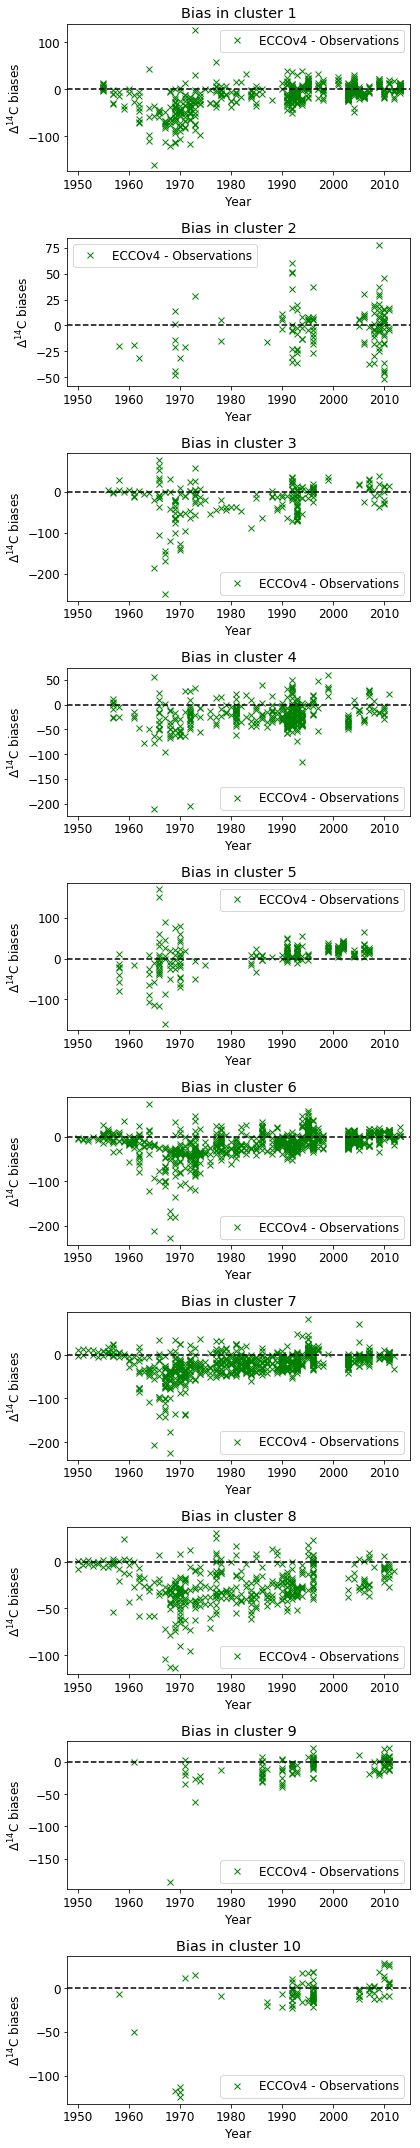

In [48]:
time_ecco_ft, bias_ecco_ft = plot_bias1(prop_map_vis_ecco, D14C_comp_real_unique_ec, D14C_inp=file_ecco_hist, lat_grid_inp=lat_grid_ec, lon_grid_inp=lon_grid_ec, mod_name="ECCOv4")

In [29]:
time_ecco_ff, bias_ecco_ff = plot_bias1(prop_map_vis_ff_ecco, D14C_comp_real_unique_ec, D14C_inp=file_ecco_hist, lat_grid_inp=lat_grid_ec, lon_grid_inp=lon_grid_ec, mod_name="ECCOv4", plot=False)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


In [50]:
time_ecco_ht, bias_ecco_ht = plot_bias1(prop_map_ht_ecco, D14C_comp_real_unique_ec, D14C_inp=file_ecco_hist, lat_grid_inp=lat_grid_ec, lon_grid_inp=lon_grid_ec, mod_name="ECCOv4", plot=False)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


In [51]:
time_ecco_hf, bias_ecco_hf = plot_bias1(prop_map_hf_ecco, D14C_comp_real_unique_ec, D14C_inp=file_ecco_hist, lat_grid_inp=lat_grid_ec, lon_grid_inp=lon_grid_ec, mod_name="ECCOv4", plot=False)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


#### 4.3 Fit according to automated algorithm

[2 0 0 2 0 2 2 2 0 0]


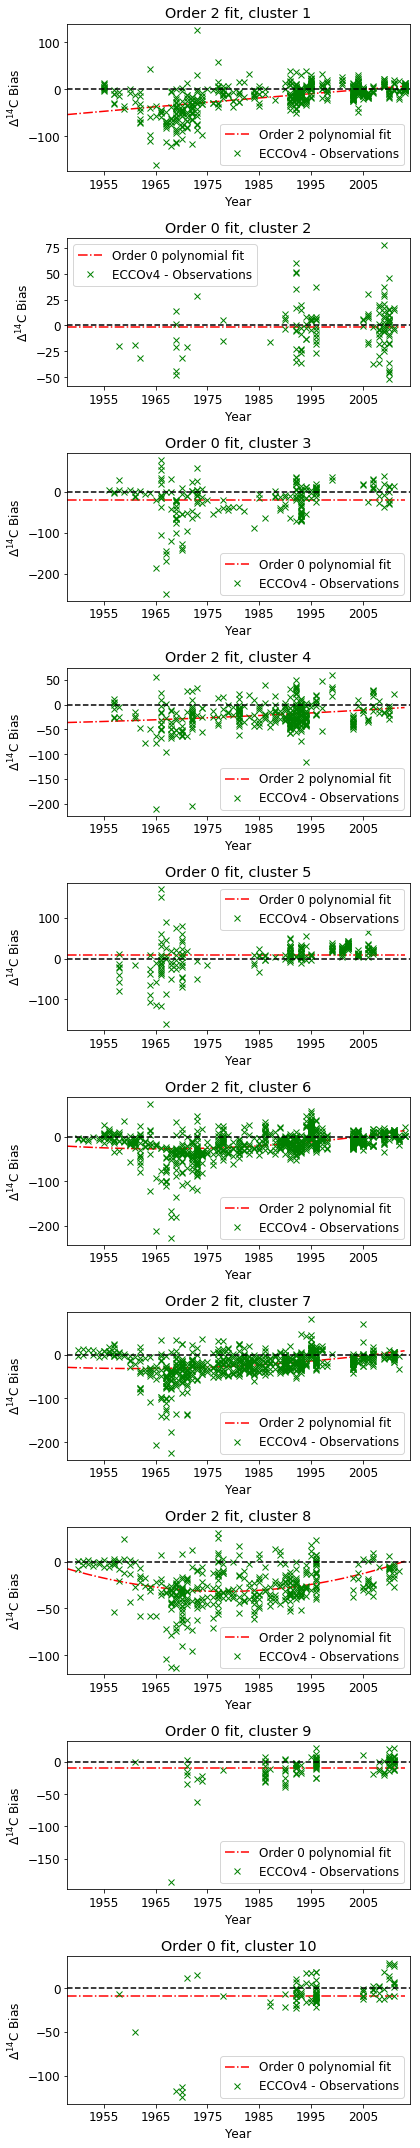

In [52]:
fitdeg_f_ec, file_ecco_hist_new = autobiascorrect_f(1950, 2012, file_ecco_hist, time_ecco_ft, bias_ecco_ft, prop_map_vis_ecco, prop_map_ecco, mod_name="ECCOv4")

In [30]:
fitdeg_f_ec, file_ecco_hist_new = autobiascorrect_f(1950, 2012, file_ecco_hist, time_ecco_ff, bias_ecco_ff, prop_map_vis_ff_ecco, prop_map_ff_ecco, mod_name="ECCOv4", plot=False)

[2 0 0 0 2 2 0 2 0 0]


In [77]:
fitdeg_f_ec, file_ecco_hist_new = autobiascorrect_h(1950, 2012, file_ecco_hist, time_ecco_hf, bias_ecco_hf, prop_map_hf_ecco, mod_name="ECCOv4", plot=False)

[0 0 2 0 2 0 2 0 2 0]


In [88]:
fitdeg_f_ec, file_ecco_hist_new = autobiascorrect_h(1950, 2012, file_ecco_hist, time_ecco_ht, bias_ecco_ht, prop_map_ht_ecco, mod_name="ECCOv4", plot=False)

[0 2 0 0 2 0 0 2 2 0]


In [89]:
# Save new D14C distribution into CSV file
for yr in range(file_ecco_hist_new.shape[0]):
    np.savetxt(f"/home/kty115/msci/Model/RC_Inventory/InterpCCSM/D14C_new_ECCOv4_ht/D14C_new_{yr+1950}_ECCOv4_ht.csv", file_ecco_hist_new[yr,0,:,:], delimiter=",")

#### 4.4 Interpolate to CCSM grid

In [54]:
D14C_compgrid_ind_CCSM_ECCOv4 = pd.read_csv("/home/kty115/msci/Model/CCSM_ECCOv4/D14C_CCSM_ECCOv4_gridinds.csv").drop("Unnamed: 0", axis=1)

In [90]:
fake_ecco_new = fake_obs_all(D14C_compgrid_ind_CCSM_ECCOv4, D14C_hist, file_ecco_hist_new, "ECCOv4")

In [91]:
fake_ecco_new.dump('ECCOv4_in_CCSM_ht')

In [172]:
fake_ecco_new = np.load('ECCOv4_in_CCSM_ft')

### Save into obs_mod_file CSV

Select the data which correpond to the years in the ECCOv4 model (1950 - 2013).

In [13]:
D14C_obsv_sel_ec = D14C_obsv[D14C_obsv['year_round'].isin(np.arange(1950,2014))]

In [31]:
assoc_lat_new_ec, assoc_lon_new_ec, assoc_D14C_new_ec = obs_mod_file_new(D14C_obsv_sel_ec, file_ecco_hist_new, lat_grid_ec, lon_grid_ec)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal
/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Warning: converting a masked element to nan.


In [32]:
# Insert into existing DataFrame
D14C_obsv_asso_n = D14C_obsv_sel_ec.copy()
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lat=assoc_lat_new_ec)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lon=assoc_lon_new_ec)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(ECCO_corr_value=assoc_D14C_new_ec)  ### CHANGE TO CURRENT MODEL NAME

In [33]:
# Remove rows which does not have an associated lat / lon
import math
remove_rows = []
for i in range(len(D14C_obsv_asso_n.index)):
    if math.isnan(D14C_obsv_asso_n["ECCO_corr_value"].iloc[i]):
        remove_rows.append(i)
        
D14C_obsv_asso_nr = D14C_obsv_asso_n.reset_index().drop(remove_rows)

In [34]:
# Reset index, drop the old one since it's useless now
D14C_obsv_asso_nr = D14C_obsv_asso_nr.reset_index().drop(["level_0", "lat", "lon", "year"], axis=1)

In [36]:
D14C_obsv_asso_nr.to_csv("ObsECCOv4_new_corr.csv")

### Calculate new inventory

In [92]:
net14C_flux_n_ec = np.ma.empty_like(fake_ecco_new[:,:,:]) # Extract surface layer

for yr_ind in range(airseaf.shape[0]):
    for lat_ind in range(fake_ecco_new.shape[1]):
        for lon_ind in range(fake_ecco_new.shape[2]):
            if np.ma.is_masked(fake_ecco_new[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_n_ec[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_ecco_new[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [93]:
bomb14C_flux_n_ec = np.ma.zeros(net14C_flux_n_ec.shape)

bomb14C_flux_n_ec[:,:,:] = net14C_flux_n_ec[:,:,:] - net14C_flux_n_ec[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [94]:
cum_bomb14C_flux_n_ec = np.ma.zeros(bomb14C_flux_n_ec.shape)

for i in range(1, cum_bomb14C_flux_n_ec.shape[0]):
    cum_bomb14C_flux_n_ec[i,:,:] = cum_bomb14C_flux_n_ec[i-1 ,:,:] + bomb14C_flux_n_ec[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [95]:
inv_n_ec = np.zeros(cum_bomb14C_flux_n_ec.shape[0])

for i in range(len(inv_n_ec)):
    inv_n_ec[i] = np.nansum(cum_bomb14C_flux_n_ec[i,:,:]*cell_area[:,:])

In [96]:
inv_n_ec

array([0.00000000e+00, 1.65376606e+05, 9.03782716e+05, 2.32587705e+06,
       5.46478053e+06, 1.63259650e+07, 4.47685195e+07, 9.01240721e+07,
       1.66782612e+08, 2.83920764e+08, 4.13178784e+08, 5.44935306e+08,
       7.06417053e+08, 9.89167053e+08, 1.37617706e+09, 1.77996631e+09,
       2.15262005e+09, 2.48845808e+09, 2.79222042e+09, 3.07977650e+09,
       3.35289758e+09, 3.61035257e+09, 3.84814022e+09, 4.06129787e+09,
       4.25638515e+09, 4.43823203e+09, 4.60500505e+09, 4.75815167e+09,
       4.90490895e+09, 5.03771475e+09, 5.15750410e+09, 5.26880460e+09,
       5.37155824e+09, 5.46475663e+09, 5.54988789e+09, 5.63184950e+09,
       5.70908175e+09, 5.78191131e+09, 5.85191012e+09, 5.91511708e+09,
       5.97281796e+09, 6.02623878e+09, 6.07589827e+09, 6.12335012e+09,
       6.16811873e+09, 6.21092832e+09, 6.25214897e+09, 6.29041244e+09,
       6.32772813e+09, 6.36324945e+09, 6.39632964e+09, 6.42731173e+09,
       6.45647743e+09, 6.48424527e+09, 6.50965813e+09, 6.53407965e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [97]:
inv_f_n_ec = inv_n_ec*10**-2*6.02e23*1e-3/1e26

In [108]:
np.savetxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_RCInv.csv", inv_f_ec, delimiter=",")
#np.savetxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_ht.csv", inv_f_n_ec, delimiter=",")

## UVic
### 1. Prepare relevant data
Import UVic data.

In [11]:
import h5py
f = h5py.File('/home/kty115/msci/Model/CCSM_UVic/UVicKielIncrIsopycDiff_RCP8.5_D14C_avg.mat','r')

file_uvic_hist = f.get('D14Cavgg')
file_uvic_hist = np.ma.masked_invalid(file_uvic_hist)

# Use f.get().value to get only the values of the variables as numpy arrays
lon_grid_1d = f.get('x')[0]
lat_grid_1d = f.get('y')[0]
lon_grid_uv, lat_grid_uv = np.meshgrid(lon_grid_1d, lat_grid_1d)
depth_uv = f.get('z')[0]
time_uv = f.get('T')[:].T[0]
f.close()
time_data_uv = time_uv[1950-1765:2014-1765]
file_uvic_hist = file_uvic_hist[1950-1765:2014-1765,:,:,:]

### 2. Interpolate to CCSM grid

In [12]:
# Credits : Gerald -------------------------------------------------------------------------------
def fake_obs_all(D14C_comp_ind, D14C_mod, D14C_fobs, fobs_name="ECCOv4", mod_name="CCSM"):
    equiv_unmk = np.zeros_like(np.concatenate((D14C_mod[:,0,:,:], D14C_mod[:1,0,:,:]), axis=0))
    equiv_mk = np.concatenate((D14C_mod[:,0,:,:].mask, D14C_mod[:1,0,:,:].mask), axis=0)
    equiv = np.ma.array(equiv_unmk, mask=equiv_mk)  # change this according to the different start/end years of obs and mod
    for year in range(equiv.shape[0]):
        for latcs, loncs, latec, lonec in zip(D14C_comp_ind[f"{mod_name}_lat_ind"], D14C_comp_ind[f"{mod_name}_lon_ind"], D14C_comp_ind[f"{fobs_name}_lat_ind"], D14C_comp_ind[f"{fobs_name}_lon_ind"]):
            if latec == 0 and lonec == 0:  # Cannot find associated grid
                equiv[year, latcs, loncs] = np.ma.masked
            else:
                equiv[year, latcs, loncs] = D14C_fobs[year,0,latec,lonec]
    return equiv

In [13]:
fake_uvic_all = np.load('UVic_in_CCSM')

### 3. Combine to form radiocarbon inventory for each year

Now we subtract the net flux of each year from the 1950 values to obtain the bomb contribution to the net flux.

In [10]:
net14C_flux_uv = np.ma.array(np.zeros_like(fake_uvic_all[:-1,:,:]), mask=fake_uvic_all[:-1,:,:].mask) # Extract surface layer

for yr_ind in range(fake_uvic_all.shape[0]-1):
    for lat_ind in range(fake_uvic_all.shape[1]):
        for lon_ind in range(fake_uvic_all.shape[2]):
            if np.ma.is_masked(fake_uvic_all[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_uv[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_uvic_all[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [11]:
bomb14C_flux_uv = np.ma.zeros(net14C_flux_uv.shape)

bomb14C_flux_uv[:,:,:] = net14C_flux_uv[:,:,:] - net14C_flux_uv[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [12]:
cum_bomb14C_flux_uv = np.ma.zeros(bomb14C_flux_uv.shape)

for i in range(1, cum_bomb14C_flux_uv.shape[0]):
    cum_bomb14C_flux_uv[i,:,:] = cum_bomb14C_flux_uv[i-1 ,:,:] + bomb14C_flux_uv[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [14]:
inv_uv = np.zeros(cum_bomb14C_flux_uv.shape[0])

for i in range(len(inv_uv)):
    inv_uv[i] = np.nansum(cum_bomb14C_flux_uv[i,:,:]*cell_area[:,:])

In [15]:
inv_uv

array([0.00000000e+00, 2.31854352e+05, 1.06144128e+06, 2.57705313e+06,
       5.74044123e+06, 1.63737483e+07, 4.41370299e+07, 8.81968629e+07,
       1.62692023e+08, 2.76776101e+08, 4.02421655e+08, 5.30424510e+08,
       6.87196097e+08, 9.62881467e+08, 1.33995172e+09, 1.73296096e+09,
       2.09620462e+09, 2.42465626e+09, 2.72280220e+09, 3.00604945e+09,
       3.27578039e+09, 3.53065613e+09, 3.76666283e+09, 3.97878790e+09,
       4.17349788e+09, 4.35536061e+09, 4.52245566e+09, 4.67609353e+09,
       4.82339702e+09, 4.95678466e+09, 5.07721156e+09, 5.18915575e+09,
       5.29248069e+09, 5.38617871e+09, 5.47167084e+09, 5.55377041e+09,
       5.63087693e+09, 5.70332570e+09, 5.77267727e+09, 5.83501828e+09,
       5.89164479e+09, 5.94372864e+09, 5.99174935e+09, 6.03721538e+09,
       6.07963133e+09, 6.11970271e+09, 6.15779366e+09, 6.19254219e+09,
       6.22593851e+09, 6.25710577e+09, 6.28539302e+09, 6.31113117e+09,
       6.33458473e+09, 6.35615103e+09, 6.37484910e+09, 6.39200734e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [16]:
inv_f_uv = inv_uv*10**-2*6.02e23*1e-3/1e26

### 4. Find new inventory using bias corrected values
#### 4.1 Load comparison file between observation and model

In [14]:
# REAL ONES FOR INVENTORY
D14C_comp_real_uv = pd.read_csv('/home/kty115/msci/Model/CCSM_UVic/ObsUVic_new2.csv')
D14C_comp_real_uv.tail()

,Unnamed: 0,index,year_round,lat_round2,lon_round2,depth,D14C,associated_lat,associated_lon,UVic_value
3972,3972,4988,2013,31.03,238.23,2.6814,18.6,31.5,239.399994,25.923089
3973,3973,4989,2013,31.64,133.76,3.1778,52.8,31.5,135.000000,34.683360
3974,3974,4990,2013,31.88,133.58,28.0015,50.3,31.5,135.000000,34.683360
3975,3975,4991,2013,32.12,133.43,3.8728,55.7,31.5,135.000000,34.683360
3976,3976,4992,2013,32.31,240.85,3.8727,16.4,31.5,239.399994,25.923089


In [15]:
D14C_comp_real_unique_uv = D14C_comp_real_uv.groupby(['year_round','associated_lat','associated_lon']).mean().reset_index() #Remove duplicates that may have been generated from the regridding procedure

In [16]:
D14C_comp_real_unique_uv = D14C_comp_real_unique_uv.drop(['depth', 'lat_round2', 'lon_round2', 'Unnamed: 0'], axis=1)
D14C_comp_real_unique_uv.columns = ['year_round', 'mod_lat','mod_lon', "index", "D14C", "mod_D14C"] #where D14C is the real observation value 

In [17]:
D14C_comp_real_unique_uv.head()

,year_round,mod_lat,mod_lon,index,D14C,mod_D14C
0,1950,-22.500000,153.000000,934.5,-52.3000,-56.393909
1,1950,-20.700001,199.800003,936.0,-49.3750,-54.381957
2,1950,-17.100000,322.200012,937.0,-54.2000,-55.159500
3,1950,-9.900000,160.199997,938.5,-53.1375,-61.334413
4,1950,-2.700000,41.400002,940.0,-63.6000,-61.303004


#### 4.2 Plot real biases

In [18]:
# Save into CSV
prop_map_vis_uvic = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Fuzz_Time_uv/Fuzz_clmap_uv.csv", delimiter=",")
prop_map_uvic = np.zeros([prop_map_vis_uvic.shape[0], prop_map_vis_uvic.shape[1], 10])
for i in range(prop_map_uvic.shape[2]):
    prop_map_uvic[:,:,i] = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Fuzz_Time_uv/Fuzz_umat_cl{0}_uv.csv".format(i), delimiter=",")

In [19]:
# Save into CSV
prop_map_vis_ff_uvic = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Fuzz_Feat_uv/FuzzF_clmap_uv.csv", delimiter=",")
prop_map_ff_uvic = np.zeros([prop_map_vis_ff_uvic.shape[0], prop_map_vis_ff_uvic.shape[1], 10])
for i in range(prop_map_ff_uvic.shape[2]):
    prop_map_ff_uvic[:,:,i] = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Fuzz_Feat_uv/FuzzF_umat_cl{0}_uv.csv".format(i), delimiter=",")

In [20]:
# Save into CSV
prop_map_ht_uvic = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Hard_Time_uv/Hard_clmap_uv.csv", delimiter=",")
prop_map_hf_uvic = np.loadtxt("/home/kty115/msci/Model/UVic_ECCOv4_test/Hard_Feat_uv/HardF_clmap_uv.csv", delimiter=",")

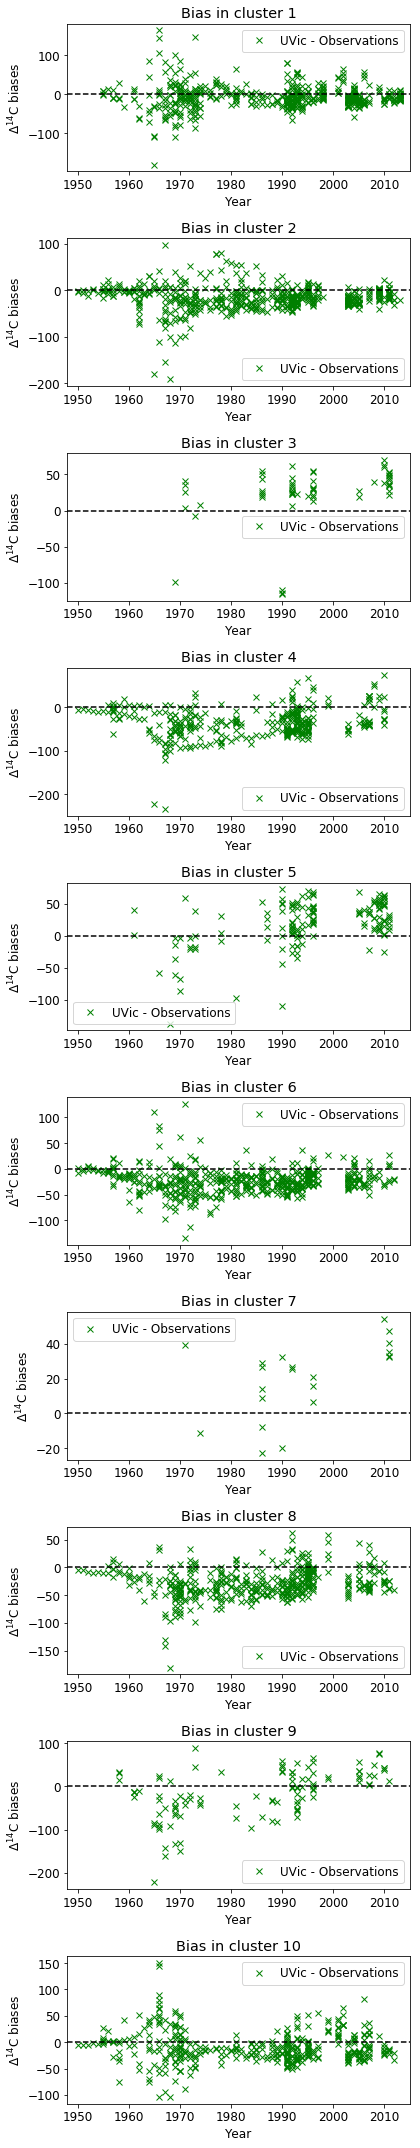

In [25]:
time_uvic_ft, bias_uvic_ft = plot_bias1(prop_map_vis_uvic, D14C_comp_real_unique_uv, D14C_inp=file_uvic_hist, lat_grid_inp=lat_grid_uv, lon_grid_inp=lon_grid_uv, mod_name="UVic")

In [26]:
time_uvic_ff, bias_uvic_ff = plot_bias1(prop_map_vis_ff_uvic, D14C_comp_real_unique_uv, D14C_inp=file_uvic_hist, lat_grid_inp=lat_grid_uv, lon_grid_inp=lon_grid_uv, mod_name="UVic", plot=False)

In [27]:
time_uvic_ht, bias_uvic_ht = plot_bias1(prop_map_ht_uvic, D14C_comp_real_unique_uv, D14C_inp=file_uvic_hist, lat_grid_inp=lat_grid_uv, lon_grid_inp=lon_grid_uv, mod_name="UVic", plot=False)

In [28]:
time_uvic_hf, bias_uvic_hf = plot_bias1(prop_map_hf_uvic, D14C_comp_real_unique_uv, D14C_inp=file_uvic_hist, lat_grid_inp=lat_grid_uv, lon_grid_inp=lon_grid_uv, mod_name="UVic", plot=False)

#### 4.3 Fit according to automated algorithm

[2 2 0 2 0 2 0 2 0 2]


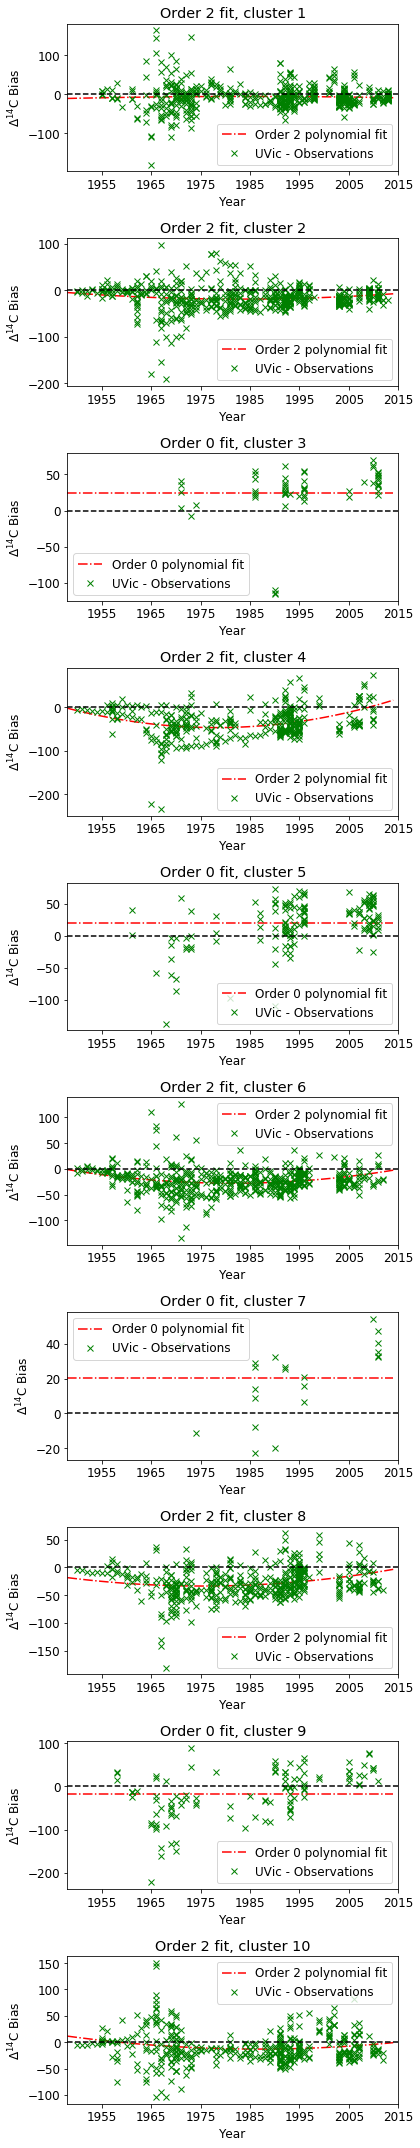

In [32]:
fitdeg_f_uv, file_uvic_hist_new = autobiascorrect_f(1950, 2013, file_uvic_hist, time_uvic_ft, bias_uvic_ft, prop_map_vis_uvic, prop_map_uvic, mod_name="UVic")

In [61]:
fitdeg_f_uv, file_uvic_hist_new = autobiascorrect_f(1950, 2013, file_uvic_hist, time_uvic_ff, bias_uvic_ff, prop_map_vis_ff_uvic, prop_map_ff_uvic, mod_name="UVic", plot=False)

[2 2 0 0 0 2 0 0 0 2]


In [63]:
fitdeg_f_uv, file_uvic_hist_new = autobiascorrect_h(1950, 2013, file_uvic_hist, time_uvic_hf, bias_uvic_hf, prop_map_hf_uvic, mod_name="UVic", plot=False)

[2 0 2 0 2 0 0 0 2 0]


In [65]:
fitdeg_f_uv, file_uvic_hist_new = autobiascorrect_h(1950, 2013, file_uvic_hist, time_uvic_ht, bias_uvic_ht, prop_map_ht_uvic, mod_name="UVic", plot=False)

[2 0 0 2 2 0 2 2 0 2]


In [66]:
# Save new D14C distribution into CSV file
for yr in range(file_uvic_hist_new.shape[0]):
    np.savetxt(f"/home/kty115/msci/Model/RC_Inventory/InterpCCSM/D14C_new_UVic_ht/D14C_new_{yr+1950}_UVic_ht.csv", file_uvic_hist_new[yr,0,:,:], delimiter=",")

#### 4.4 Interpolate to CCSM grid

In [34]:
D14C_compgrid_ind_CCSM_UVic = pd.read_csv("/home/kty115/msci/Model/CCSM_UVic/D14C_CCSM_UVic_gridinds.csv").drop("Unnamed: 0", axis=1)

In [35]:
fake_uvic_new = fake_obs_all(D14C_compgrid_ind_CCSM_UVic, D14C_hist, file_uvic_hist_new, "UVic")

In [36]:
fake_uvic_new.dump('UVic_in_CCSM_ft')

In [172]:
fake_uvic_new = np.load('UVic_in_CCSM_ht')

### Save into obs_mod_file CSV

Select the data which correpond to the years in the UVic model (1950 - 2013).

In [55]:
D14C_obsv_sel_uv = D14C_obsv[D14C_obsv['year_round'].isin(np.arange(1950,2014))]

In [56]:
assoc_lat_new_uv, assoc_lon_new_uv, assoc_D14C_new_uv = obs_mod_file_new(D14C_obsv_sel_uv, file_uvic_hist_new, lat_grid_uv, lon_grid_uv)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Warning: converting a masked element to nan.


In [57]:
# Insert into existing DataFrame
D14C_obsv_asso_n = D14C_obsv_sel_uv.copy()
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lat=assoc_lat_new_uv)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lon=assoc_lon_new_uv)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(UVic_corr_value=assoc_D14C_new_uv)  ### CHANGE TO CURRENT MODEL NAME

In [58]:
# Remove rows which does not have an associated lat / lon
import math
remove_rows = []
for i in range(len(D14C_obsv_asso_n.index)):
    if math.isnan(D14C_obsv_asso_n["UVic_corr_value"].iloc[i]):
        remove_rows.append(i)
        
D14C_obsv_asso_nr = D14C_obsv_asso_n.reset_index().drop(remove_rows)

In [59]:
# Reset index, drop the old one since it's useless now
D14C_obsv_asso_nr = D14C_obsv_asso_nr.reset_index().drop(["level_0", "lat", "lon", "year"], axis=1)

In [60]:
D14C_obsv_asso_nr.to_csv("ObsUVic_new_corr.csv")

### Calculate new inventory

In [44]:
net14C_flux_n_uv = np.ma.empty_like(fake_uvic_new[:-1,:,:]) # Extract surface layer

for yr_ind in range(airseaf.shape[0]):
    for lat_ind in range(fake_uvic_new.shape[1]):
        for lon_ind in range(fake_uvic_new.shape[2]):
            if np.ma.is_masked(fake_uvic_new[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_n_uv[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_uvic_new[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [45]:
bomb14C_flux_n_uv = np.ma.zeros(net14C_flux_n_uv.shape)

bomb14C_flux_n_uv[:,:,:] = net14C_flux_n_uv[:,:,:] - net14C_flux_n_uv[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [46]:
cum_bomb14C_flux_n_uv = np.ma.zeros(bomb14C_flux_n_uv.shape)

for i in range(1, cum_bomb14C_flux_n_uv.shape[0]):
    cum_bomb14C_flux_n_uv[i,:,:] = cum_bomb14C_flux_n_uv[i-1 ,:,:] + bomb14C_flux_n_uv[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [49]:
inv_n_uv = np.zeros(cum_bomb14C_flux_n_uv.shape[0])

for i in range(len(inv_n_uv)):
    inv_n_uv[i] = np.nansum(cum_bomb14C_flux_n_uv[i,:,:]*cell_area[:,:])

In [177]:
inv_n_uv

array([ 0.00000000e+00, -4.26789644e+05, -8.86495996e+05, -1.27226904e+06,
       -6.06852524e+05,  6.94484326e+06,  3.10446189e+07,  7.08745726e+07,
        1.40573398e+08,  2.49295841e+08,  3.69111403e+08,  4.90830474e+08,
        6.40798716e+08,  9.08984817e+08,  1.27802312e+09,  1.66267233e+09,
        2.01726907e+09,  2.33681318e+09,  2.62579905e+09,  2.89962130e+09,
        3.15967688e+09,  3.40465721e+09,  3.63057337e+09,  3.83244503e+09,
        4.01673641e+09,  4.18804332e+09,  4.34445808e+09,  4.48731271e+09,
        4.62374086e+09,  4.74620059e+09,  4.85566886e+09,  4.95663117e+09,
        5.04897693e+09,  5.13172065e+09,  5.20630790e+09,  5.27756423e+09,
        5.34391831e+09,  5.40572973e+09,  5.46458612e+09,  5.51660319e+09,
        5.56310556e+09,  5.60529265e+09,  5.64366765e+09,  5.67976631e+09,
        5.71311870e+09,  5.74445646e+09,  5.77417034e+09,  5.80092966e+09,
        5.82674578e+09,  5.85077127e+09,  5.87238446e+09,  5.89194500e+09,
        5.90975017e+09,  

In [50]:
inv_n_uv

array([ 0.00000000e+00, -3.85823933e+05, -7.67719542e+05, -1.03767210e+06,
       -2.23764527e+05,  7.48907541e+06,  3.17249550e+07,  7.16457453e+07,
        1.41351869e+08,  2.49960586e+08,  3.69713128e+08,  4.91380352e+08,
        6.41093077e+08,  9.08433756e+08,  1.27643221e+09,  1.66018760e+09,
        2.01401849e+09,  2.33293280e+09,  2.62140684e+09,  2.89476530e+09,
        3.15439908e+09,  3.39902227e+09,  3.62465055e+09,  3.82632747e+09,
        4.01046510e+09,  4.18167915e+09,  4.33803928e+09,  4.48087727e+09,
        4.61730667e+09,  4.73982303e+09,  4.84940537e+09,  4.95049630e+09,
        5.04300199e+09,  5.12592759e+09,  5.20072033e+09,  5.27218976e+09,
        5.33876820e+09,  5.40080785e+09,  5.45989792e+09,  5.51215862e+09,
        5.55891172e+09,  5.60135246e+09,  5.63997629e+09,  5.67631902e+09,
        5.70990617e+09,  5.74146958e+09,  5.77139624e+09,  5.79835537e+09,
        5.82435011e+09,  5.84853520e+09,  5.87028861e+09,  5.88996789e+09,
        5.90786805e+09,  

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [51]:
inv_f_n_uv = inv_n_uv*10**-2*6.02e23*1e-3/1e26

In [52]:
#np.savetxt("/home/kty115/msci/Model/RC_Inventory/UVic_RCInv.csv", inv_f_uv, delimiter=",")
np.savetxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_ft.csv", inv_f_n_uv, delimiter=",")

## ECCO old
### 1. Prepare relevant data
Import old ECCO data.

In [13]:
import h5py
f = h5py.File('/home/kty115/msci/Model/ECCOold/MITgcm_ECCO_RCP8.5_D14C_avg.mat','r')

file_eccoo_hist = f.get('D14Cavgg')
file_eccoo_hist = file_eccoo_hist[1950-1765:2014-1765,:,:,:]
file_eccoo_hist = np.ma.masked_invalid(file_eccoo_hist)

# Use f.get().value to get only the values of the variables as numpy arrays
lon_grid_1d_ec = f.get('x')[0]
lat_grid_1d_ec = f.get('y')[0]
lon_grid_eco, lat_grid_eco = np.meshgrid(lon_grid_1d_ec, lat_grid_1d_ec)
depth_eco = f.get('z')[0]
time_eco = f.get('T')[:].T[0]
f.close()
time_data_eco = time_eco[1950-1765:2014-1765]

### 2. Interpolate to CCSM grid

In [14]:
fake_eccoo_all = np.load('ECCOold_in_CCSM')

### 3. Combine to form radiocarbon inventory for each year

Now we subtract the net flux of each year from the 1950 values to obtain the bomb contribution to the net flux.

In [21]:
net14C_flux_eco = np.ma.array(np.zeros_like(fake_eccoo_all[:-1,:,:]), mask=fake_eccoo_all[:-1,:,:].mask) # Extract surface layer

for yr_ind in range(airseaf.shape[0]):
    for lat_ind in range(fake_eccoo_all.shape[1]):
        for lon_ind in range(fake_eccoo_all.shape[2]):
            if np.ma.is_masked(fake_eccoo_all[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_eco[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_eccoo_all[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [22]:
bomb14C_flux_eco = np.ma.zeros(net14C_flux_eco.shape)

bomb14C_flux_eco[:,:,:] = net14C_flux_eco[:,:,:] - net14C_flux_eco[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [23]:
cum_bomb14C_flux_eco = np.ma.zeros(bomb14C_flux_eco.shape)

for i in range(1, cum_bomb14C_flux_eco.shape[0]):
    cum_bomb14C_flux_eco[i,:,:] = cum_bomb14C_flux_eco[i-1 ,:,:] + bomb14C_flux_eco[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [24]:
inv_eco = np.zeros(cum_bomb14C_flux_eco.shape[0])

for i in range(len(inv_eco)):
    inv_eco[i] = np.nansum(cum_bomb14C_flux_eco[i,:,:]*cell_area[:,:])

In [25]:
inv_eco

array([0.00000000e+00, 2.37942874e+05, 1.08450332e+06, 2.63228864e+06,
       5.85160627e+06, 1.65836236e+07, 4.45081530e+07, 8.88177639e+07,
       1.63656897e+08, 2.78154027e+08, 4.04411704e+08, 5.32865552e+08,
       6.89650641e+08, 9.64847481e+08, 1.34198045e+09, 1.73542678e+09,
       2.09826097e+09, 2.42483794e+09, 2.71955544e+09, 2.99792765e+09,
       3.26162290e+09, 3.50953948e+09, 3.73779361e+09, 3.94150450e+09,
       4.12717036e+09, 4.29956370e+09, 4.45685291e+09, 4.60045239e+09,
       4.73756054e+09, 4.86071613e+09, 4.97087948e+09, 5.07249209e+09,
       5.16549911e+09, 5.24890285e+09, 5.32415676e+09, 5.39608555e+09,
       5.46312808e+09, 5.52561037e+09, 5.58510199e+09, 5.63767876e+09,
       5.68462137e+09, 5.72710533e+09, 5.76561488e+09, 5.80167788e+09,
       5.83480475e+09, 5.86570352e+09, 5.89473718e+09, 5.92053695e+09,
       5.94508102e+09, 5.96750688e+09, 5.98716664e+09, 6.00438521e+09,
       6.01943132e+09, 6.03270144e+09, 6.04322057e+09, 6.05231831e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [26]:
inv_f_eco = inv_eco*10**-2*6.02e23*1e-3/1e26

### 4. Find new inventory using bias corrected values
#### 4.1 Load comparison file between observation and model

In [77]:
# REAL ONES FOR INVENTORY
D14C_comp_real_eco = pd.read_csv('/home/kty115/msci/Model/ECCOold/ObsoldECCO_new2.csv')
D14C_comp_real_eco.head()

,Unnamed: 0,year_round,lat_round2,lon_round2,Unnamed: 0.1,lat,lon,year,depth,D14C,mod_lat,mod_lon,mod_D14C
0,0,1950,-23.00,152.00,934,-23.00,152.00,1950.0,0.0,-52.400,-23.5,151.5,-47.653430
1,1,1950,-22.00,153.00,935,-22.00,153.00,1950.0,0.0,-52.200,-22.5,152.5,-48.803962
2,2,1950,-21.23,200.18,936,-21.23,200.18,1950.0,18.0,-49.375,-21.5,200.5,-44.381629
3,3,1950,-17.50,320.67,937,-17.50,320.67,1950.0,0.0,-54.200,-17.5,321.5,-52.182834
4,4,1950,-9.53,160.20,938,-9.53,160.20,1950.0,0.0,-53.900,-9.5,159.5,-50.468591


In [78]:
D14C_comp_real_unique_eco = D14C_comp_real_eco.groupby(['year_round','mod_lat','mod_lon']).mean().reset_index() #Remove duplicates that may have been generated from the regridding procedure

In [79]:
D14C_comp_real_unique_eco = D14C_comp_real_unique_eco.drop(['depth', 'lat_round2', 'lon_round2', 'Unnamed: 0', 'Unnamed: 0.1', 'lat', 'lon'], axis=1)
D14C_comp_real_unique_eco.columns = ['year_round', 'mod_lat','mod_lon', "index", "D14C", "mod_D14C"] #where D14C is the real observation value 

In [80]:
D14C_comp_real_unique_eco.head()

,year_round,mod_lat,mod_lon,index,D14C,mod_D14C
0,1950,-23.5,151.5,1950.0,-52.4000,-47.653430
1,1950,-22.5,152.5,1950.0,-52.2000,-48.803962
2,1950,-21.5,200.5,1950.0,-49.3750,-44.381629
3,1950,-17.5,321.5,1950.0,-54.2000,-52.182834
4,1950,-9.5,159.5,1950.0,-53.1375,-50.468591


#### 4.2 Plot real biases

In [41]:
# Save into CSV
prop_map_vis_eccoo = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Fuzz_Time_ec/Fuzz_clmap_ec.csv", delimiter=",")
prop_map_eccoo = np.zeros([prop_map_vis_eccoo.shape[0], prop_map_vis_eccoo.shape[1], 10])
for i in range(prop_map_eccoo.shape[2]):
    prop_map_eccoo[:,:,i] = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Fuzz_Time_ec/Fuzz_umat_cl{0}_ec.csv".format(i), delimiter=",")

In [81]:
# Save into CSV
prop_map_vis_ff_eccoo = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Fuzz_Feat_ec/FuzzF_clmap_ec.csv", delimiter=",")
prop_map_ff_eccoo = np.zeros([prop_map_vis_ff_eccoo.shape[0], prop_map_vis_ff_eccoo.shape[1], 10])
for i in range(prop_map_ff_eccoo.shape[2]):
    prop_map_ff_eccoo[:,:,i] = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Fuzz_Feat_ec/FuzzF_umat_cl{0}_ec.csv".format(i), delimiter=",")

In [44]:
# Save into CSV
prop_map_ht_eccoo = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Hard_Time_ec/Hard_clmap_ec.csv", delimiter=",")
prop_map_hf_eccoo = np.loadtxt("/home/kty115/msci/Model/ECCOold_UVic/Hard_Feat_ec/HardF_clmap_ec.csv", delimiter=",")

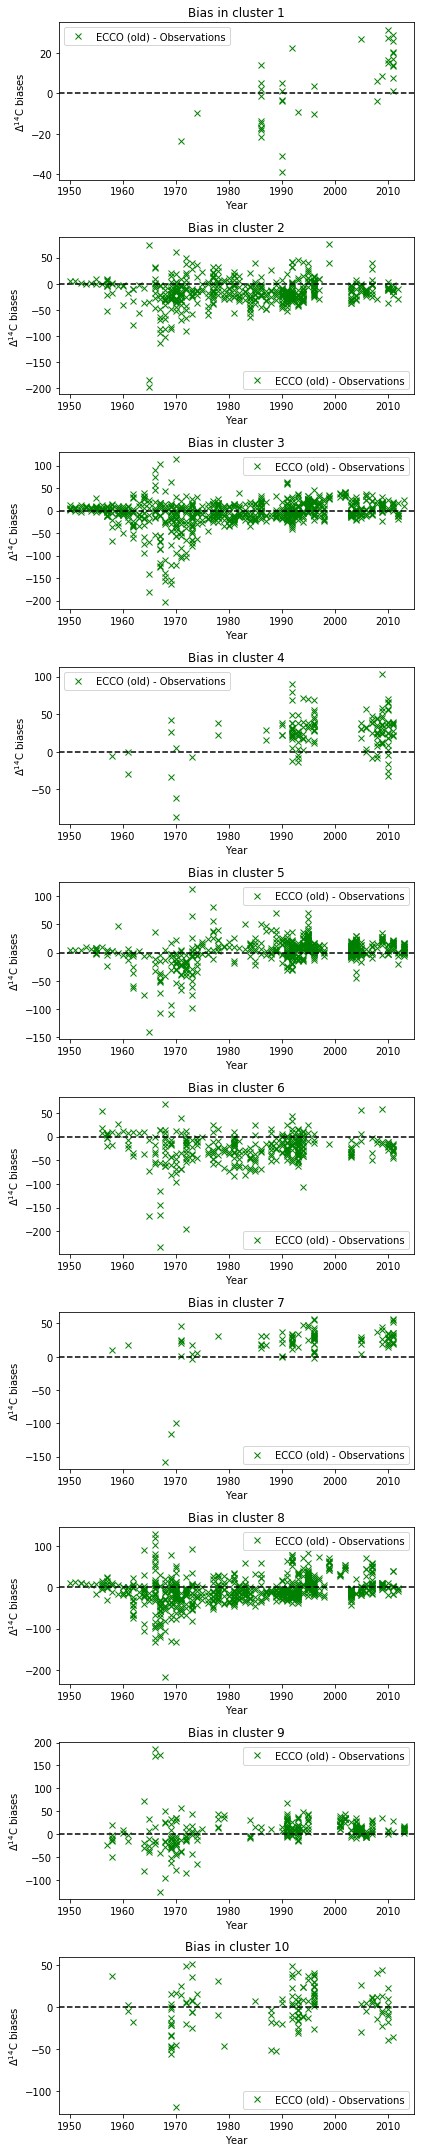

In [57]:
time_eccoo, bias_eccoo = plot_bias1(prop_map_vis_eccoo, D14C_comp_real_unique_eco, D14C_inp=file_eccoo_hist, lat_grid_inp=lat_grid_eco, lon_grid_inp=lon_grid_eco, mod_name="ECCO (old)")

In [90]:
time_eccoo_ff, bias_eccoo_ff = plot_bias1(prop_map_vis_ff_eccoo, D14C_comp_real_unique_eco, D14C_inp=file_eccoo_hist, lat_grid_inp=lat_grid_eco, lon_grid_inp=lon_grid_eco, mod_name="ECCO (old)", plot=False)

In [58]:
time_eccoo_ht, bias_eccoo_ht = plot_bias1(prop_map_ht_eccoo, D14C_comp_real_unique_eco, D14C_inp=file_eccoo_hist, lat_grid_inp=lat_grid_eco, lon_grid_inp=lon_grid_eco, mod_name="ECCO (old)", plot=False)

In [59]:
time_eccoo_hf, bias_eccoo_hf = plot_bias1(prop_map_hf_eccoo, D14C_comp_real_unique_eco, D14C_inp=file_eccoo_hist, lat_grid_inp=lat_grid_eco, lon_grid_inp=lon_grid_eco, mod_name="ECCO (old)", plot=False)

#### 4.3 Fit according to automated algorithm

[0 2 2 0 2 2 0 2 2 0]


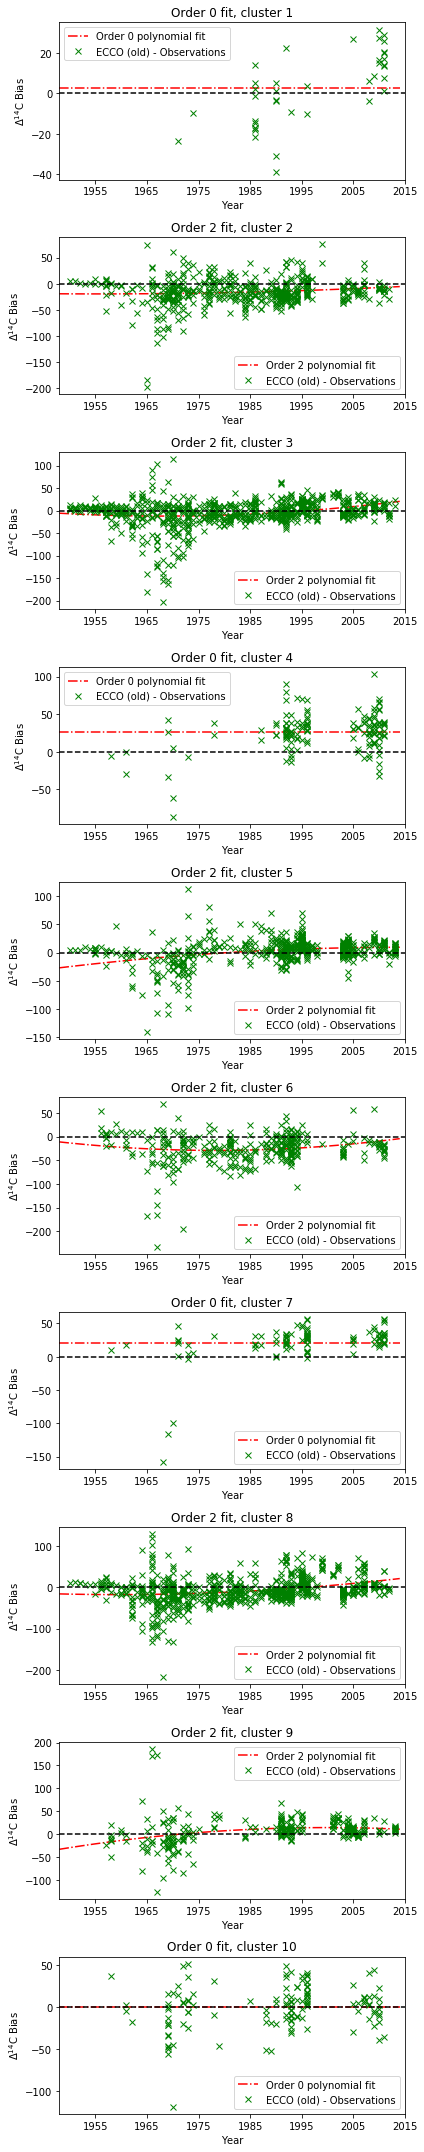

In [97]:
fitdeg_f_eco, file_eccoo_hist_new = autobiascorrect_f(1950, 2013, file_eccoo_hist, time_eccoo, bias_eccoo, prop_map_vis_eccoo, prop_map_eccoo, mod_name="ECCO (old)")

In [67]:
# Save new D14C distribution into CSV file
for yr in range(file_eccoo_hist_new.shape[0]):
    np.savetxt(f"/home/kty115/msci/Model/RC_Inventory/InterpCCSM/D14C_new_ECCOold_hf/D14C_new_{yr+1950}_ECCOold_hf.csv", file_eccoo_hist_new[yr,0,:,:], delimiter=",")

In [92]:
fitdeg_f_eco, file_eccoo_hist_new = autobiascorrect_f(1950, 2013, file_eccoo_hist, time_eccoo_ff, bias_eccoo_ff, prop_map_vis_ff_eccoo, prop_map_ff_eccoo, mod_name="ECCO (old)", plot=False)

[0 2 2 0 2 0 0 2 2 0]


In [77]:
fitdeg_f_eco, file_eccoo_hist_new = autobiascorrect_h(1950, 2013, file_eccoo_hist, time_eccoo_ht, bias_eccoo_ht, prop_map_ht_eccoo, mod_name="ECCO (old)", plot=False)

[2 0 0 2 0 2 0 2 2 0]


In [66]:
fitdeg_f_eco, file_eccoo_hist_new = autobiascorrect_h(1950, 2013, file_eccoo_hist, time_eccoo_hf, bias_eccoo_hf, prop_map_hf_eccoo, mod_name="ECCO (old)", plot=False)

[2 0 2 2 0 0 0 2 2 0]


#### 4.4 Interpolate to CCSM grid

In [93]:
D14C_compgrid_ind_CCSM_ECCOold = pd.read_csv("/home/kty115/msci/Model/CCSM_UVic/D14C_CCSM_ECCO_old_gridinds.csv").drop("Unnamed: 0", axis=1)

In [101]:
fake_eccoo_new = fake_obs_all(D14C_compgrid_ind_CCSM_ECCOold, D14C_hist, file_eccoo_hist_new, "ECCO_old")

In [102]:
fake_eccoo_new.dump('ECCOold_in_CCSM_ff')

In [133]:
fake_eccoo_new = np.load('ECCOold_in_CCSM_hf')

### Save into obs_mod_file CSV

Select the data which correpond to the years in the UVic model (1950 - 2013).

In [16]:
D14C_obsv_sel_eco = D14C_obsv[D14C_obsv['year_round'].isin(np.arange(1950,2014))]

In [19]:
assoc_lat_eco, assoc_lon_eco, assoc_D14C_eco = obs_mod_file_new(D14C_obsv_sel_eco, file_eccoo_hist, lat_grid_eco, lon_grid_eco)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Warning: converting a masked element to nan.


In [96]:
assoc_lat_new_eco, assoc_lon_new_eco, assoc_D14C_new_eco = obs_mod_file_new(D14C_obsv_sel_eco, file_eccoo_hist_new, lat_grid_eco, lon_grid_eco)

/home/kty115/anaconda3/envs/zeus1/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Warning: converting a masked element to nan.


In [21]:
# Insert into existing DataFrame
D14C_obsv_asso_n = D14C_obsv_sel_eco.copy()
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lat=assoc_lat_eco)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lon=assoc_lon_eco)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(ECCOold_value=assoc_D14C_eco)  ### CHANGE TO CURRENT MODEL NAME

In [98]:
# Insert into existing DataFrame
D14C_obsv_asso_n = D14C_obsv_sel_eco.copy()
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lat=assoc_lat_new_eco)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(associated_lon=assoc_lon_new_eco)
D14C_obsv_asso_n = D14C_obsv_asso_n.assign(ECCOold_corr_value=assoc_D14C_new_eco)  ### CHANGE TO CURRENT MODEL NAME

In [99]:
# Remove rows which does not have an associated lat / lon
import math
remove_rows = []
for i in range(len(D14C_obsv_asso_n.index)):
    if math.isnan(D14C_obsv_asso_n["ECCOold_corr_value"].iloc[i]):
        remove_rows.append(i)
        
D14C_obsv_asso_nr = D14C_obsv_asso_n.reset_index().drop(remove_rows)

In [22]:
# Remove rows which does not have an associated lat / lon
import math
remove_rows = []
for i in range(len(D14C_obsv_asso_n.index)):
    if math.isnan(D14C_obsv_asso_n["ECCOold_value"].iloc[i]):
        remove_rows.append(i)
        
D14C_obsv_asso_nr = D14C_obsv_asso_n.reset_index().drop(remove_rows)

In [23]:
# Reset index, drop the old one since it's useless now
D14C_obsv_asso_nr = D14C_obsv_asso_nr.reset_index().drop(["level_0", "lat", "lon", "year"], axis=1)

In [101]:
D14C_obsv_asso_nr.to_csv("ObsECCOold_new_corr.csv")

In [24]:
D14C_obsv_asso_nr.to_csv("ObsECCOold_new2.csv")

### Calculate new inventory

In [134]:
net14C_flux_n_eco = np.ma.array(np.zeros_like(fake_eccoo_new[:-1,:,:]), mask=fake_eccoo_new[:-1,:,:].mask) # Extract surface layer

for yr_ind in range(net14C_flux_n_eco.shape[0]):
    for lat_ind in range(fake_eccoo_new.shape[1]):
        for lon_ind in range(fake_eccoo_new.shape[2]):
            if np.ma.is_masked(fake_eccoo_new[yr_ind, lat_ind, lon_ind]):
                continue
            else:
                # Separate into latitude bands to extract atm D14C values
                lat_point = lat_gridc[lat_ind, lon_ind]
                if lat_point < -30: # -90 to -30, SH
                    D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                elif lat_point < 30: # -30 to 30, Tropics
                    D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                else: # 30 to 90, NH
                    D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                net14C_flux_n_eco[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (fake_eccoo_new[yr_ind, lat_ind, lon_ind]/1000+1)) * 1.17e-12

In [135]:
bomb14C_flux_n_eco = np.ma.zeros(net14C_flux_n_eco.shape)

bomb14C_flux_n_eco[:,:,:] = net14C_flux_n_eco[:,:,:] - net14C_flux_n_eco[0,:,:]

For each grid, we sum the bomb fluxes over the years between 1950 to the year of interest.

In [136]:
cum_bomb14C_flux_n_eco = np.ma.zeros(bomb14C_flux_n_eco.shape)

for i in range(1, cum_bomb14C_flux_n_eco.shape[0]):
    cum_bomb14C_flux_n_eco[i,:,:] = cum_bomb14C_flux_n_eco[i-1 ,:,:] + bomb14C_flux_n_eco[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year

In [137]:
inv_n_eco = np.zeros(cum_bomb14C_flux_n_eco.shape[0])

for i in range(len(inv_n_eco)):
    inv_n_eco[i] = np.nansum(cum_bomb14C_flux_n_eco[i,:,:]*cell_area[:,:])

In [130]:
inv_n_eco

array([0.00000000e+00, 2.29520687e+05, 1.08159183e+06, 2.64848145e+06,
       5.90931516e+06, 1.67317380e+07, 4.48386223e+07, 8.94469601e+07,
       1.64744985e+08, 2.79902509e+08, 4.06856352e+08, 5.36085378e+08,
       6.93944468e+08, 9.70905348e+08, 1.35010220e+09, 1.74557588e+09,
       2.11042444e+09, 2.43899939e+09, 2.73572155e+09, 3.01617976e+09,
       3.28205354e+09, 3.53222392e+09, 3.76280814e+09, 3.96890662e+09,
       4.15707609e+09, 4.33207387e+09, 4.49209748e+09, 4.63856717e+09,
       4.77870817e+09, 4.90502736e+09, 5.01849015e+09, 5.12358759e+09,
       5.22025463e+09, 5.30750951e+09, 5.38681101e+09, 5.46300653e+09,
       5.53453879e+09, 5.60174875e+09, 5.66621186e+09, 5.72400708e+09,
       5.77642605e+09, 5.82465615e+09, 5.86919670e+09, 5.91158307e+09,
       5.95133787e+09, 5.98917712e+09, 6.02547595e+09, 6.05887396e+09,
       6.09136604e+09, 6.12209636e+09, 6.15042618e+09, 6.17669147e+09,
       6.20117271e+09, 6.22427726e+09, 6.24504231e+09, 6.26481197e+09,
      

Summing up over the years (sec) and over all areas (m$^2$) gives units mmol DIC/m cm. The /m and cm can cancel with a factor of $10^{-2}$ to give unit of inventory as mmol DIC. $1 \text{ mol} = 6.02 \times 10^{23} \text{ atoms}$ so we multiply by this factor and $10^{-3}$ (**m**mol). Finally divide by $10^{26}$ to give the required units.

In [139]:
inv_f_n_eco = inv_n_eco*10**-2*6.02e23*1e-3/1e26

In [140]:
#np.savetxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_RCInv.csv", inv_f_ec, delimiter=",")
np.savetxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_hf.csv", inv_f_n_eco, delimiter=",")

## Plotting the inventory with reference value
Let's plot the inventory with observation-based estimates of the bomb $^{14}C$ inventory from Naegler (2009), $(374 \pm 98) \times 10^{26}$ atoms in 1995 and $(252 \pm 25) \times 10^{26}$ atoms in 1975.

In [53]:
inv_f_eco = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_RCInv.csv", delimiter=",")
inv_f_n_eco = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_ff.csv", delimiter=",")
inv_f = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv.csv", delimiter=",")
inv_f_n = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_ff.csv", delimiter=",")
inv_f_ec = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_RCInv.csv", delimiter=",")
inv_f_n_ec = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_ff.csv", delimiter=",")
inv_f_uv = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_RCInv.csv", delimiter=",")
inv_f_n_uv = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_ft.csv", delimiter=",")

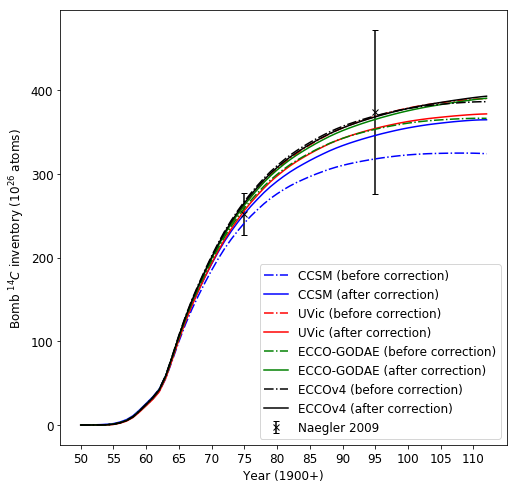

In [10]:
# Plot inventories
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(np.arange(50, 113), inv_f, 'b-.', label="CCSM (before correction)")
ax.plot(np.arange(50, 113), inv_f_n, 'b-', label="CCSM (after correction)")
ax.plot(np.arange(50, 113), inv_f_uv, 'r-.', label="UVic (before correction)")
ax.plot(np.arange(50, 113), inv_f_n_uv, 'r-', label="UVic (after correction)")
ax.plot(np.arange(50, 113), inv_f_eco, 'g-.', label="ECCO-GODAE (before correction)")
ax.plot(np.arange(50, 113), inv_f_n_eco, 'g-', label="ECCO-GODAE (after correction)")
ax.plot(np.arange(50, 113), inv_f_ec, 'k-.', label="ECCOv4 (before correction)")
ax.plot(np.arange(50, 113), inv_f_n_ec, 'k-', label="ECCOv4 (after correction)")

# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (1900+)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

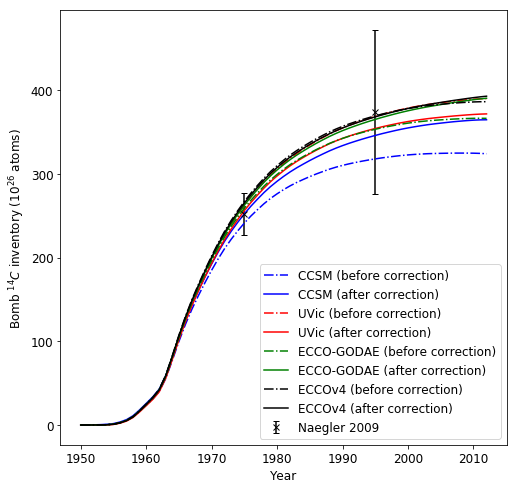

In [9]:
# Plot inventories
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(np.arange(1950, 2013), inv_f, 'b-.', label="CCSM (before correction)")
ax.plot(np.arange(1950, 2013), inv_f_n, 'b-', label="CCSM (after correction)")
ax.plot(np.arange(1950, 2013), inv_f_uv, 'r-.', label="UVic (before correction)")
ax.plot(np.arange(1950, 2013), inv_f_n_uv, 'r-', label="UVic (after correction)")
ax.plot(np.arange(1950, 2013), inv_f_eco, 'g-.', label="ECCO-GODAE (before correction)")
ax.plot(np.arange(1950, 2013), inv_f_n_eco, 'g-', label="ECCO-GODAE (after correction)")
ax.plot(np.arange(1950, 2013), inv_f_ec, 'k-.', label="ECCOv4 (before correction)")
ax.plot(np.arange(1950, 2013), inv_f_n_ec, 'k-', label="ECCOv4 (after correction)")

# Reference values
ax.errorbar([1975, 1995], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(1950, 2015, 10))
ax.legend()

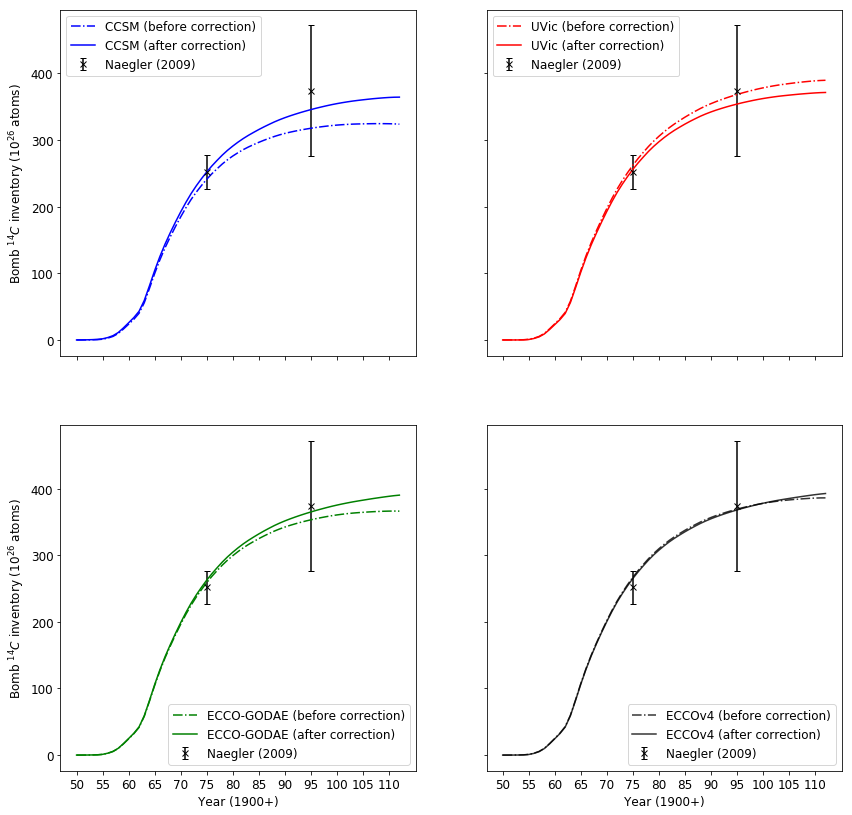

In [21]:
# Plot inventories
fig, ax = plt.subplots(2, 2, figsize=(14,14), sharex='col', sharey='row')

ax[0,0].plot(np.arange(50, 113), inv_f, 'b-.', label="CCSM (before correction)")
ax[0,0].plot(np.arange(50, 113), inv_f_n, 'b-', label="CCSM (after correction)")
ax[0,1].plot(np.arange(50, 113), inv_f_uv, 'r-.', label="UVic (before correction)")
ax[0,1].plot(np.arange(50, 113), inv_f_n_uv, 'r-', label="UVic (after correction)")
ax[1,0].plot(np.arange(50, 113), inv_f_eco, 'g-.', label="ECCO-GODAE (before correction)")
ax[1,0].plot(np.arange(50, 113), inv_f_n_eco, 'g-', label="ECCO-GODAE (after correction)")
ax[1,1].plot(np.arange(50, 113), inv_f_ec, 'k-.', alpha=0.8, label="ECCOv4 (before correction)")
ax[1,1].plot(np.arange(50, 113), inv_f_n_ec, 'k-', alpha=0.8, label="ECCOv4 (after correction)")

# Reference values
for i in range(2):
    for j in range(2):
        ax[i,j].errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler (2009)")
        ax[i,j].legend()
        ax[i,j].set_xticks(np.arange(50, 115, 5))
        
for axx in ax.flat:
    axx.set(xlabel="Year (1900+)", ylabel=r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

In [18]:
plt.rcParams.update({'font.size': 9})

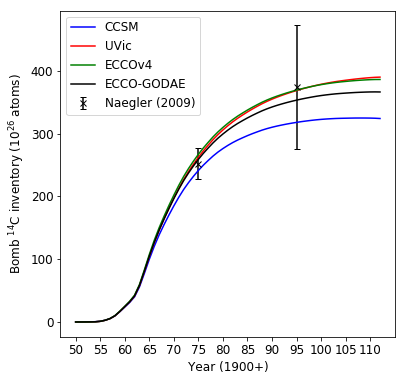

In [20]:
# Plot inventories BEFORE CORRECTION
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(np.arange(50, 113), inv_f, 'b-', label="CCSM")
ax.plot(np.arange(50, 113), inv_f_uv, 'r-', label="UVic")
ax.plot(np.arange(50, 113), inv_f_ec, 'g-', label="ECCOv4")
ax.plot(np.arange(50, 113), inv_f_eco, 'k-', label="ECCO-GODAE")


# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler (2009)")
ax.set_xlabel("Year (1900+)")
ax.set_ylabel(r"Bomb $^{14}$C inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

In [135]:
inv_f = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv.csv", delimiter=",")
inv_f_ft = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_ft.csv", delimiter=",")
inv_f_ff = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_ff.csv", delimiter=",")
inv_f_ht = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_ht.csv", delimiter=",")
inv_f_hf = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/CCSM_RCInv_cor_hf.csv", delimiter=",")

In [22]:
inv_f = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_RCInv.csv", delimiter=",")
inv_f_ft = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_ft.csv", delimiter=",")
inv_f_ff = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_ff.csv", delimiter=",")
inv_f_ht = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_ht.csv", delimiter=",")
inv_f_hf = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/UVic_intRCInv_hf.csv", delimiter=",")

In [141]:
inv_f = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_RCInv.csv", delimiter=",")
inv_f_ft = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_ft.csv", delimiter=",")
inv_f_ff = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_ff.csv", delimiter=",")
inv_f_ht = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_ht.csv", delimiter=",")
inv_f_hf = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOold_intRCInv_hf.csv", delimiter=",")

In [111]:
inv_f = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_RCInv.csv", delimiter=",")
inv_f_ft = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_ft.csv", delimiter=",")
inv_f_ff = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_ff.csv", delimiter=",")
inv_f_ht = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_ht.csv", delimiter=",")
inv_f_hf = np.loadtxt("/home/kty115/msci/Model/RC_Inventory/ECCOv4_intRCInv_hf.csv", delimiter=",")

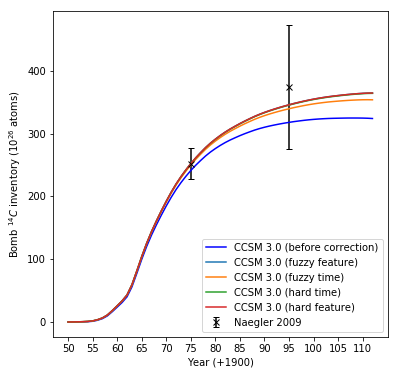

In [136]:
# Plot inventories
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(np.arange(50, 113), inv_f, 'b-', label="CCSM 3.0 (before correction)")
ax.plot(np.arange(50, 113), inv_f_ff, '-', label="CCSM 3.0 (fuzzy feature)")
ax.plot(np.arange(50, 113), inv_f_ft, '-', label="CCSM 3.0 (fuzzy time)")
ax.plot(np.arange(50, 113), inv_f_ht, '-', label="CCSM 3.0 (hard time)")
ax.plot(np.arange(50, 113), inv_f_hf, '-', label="CCSM 3.0 (hard feature)")
# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (+1900)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

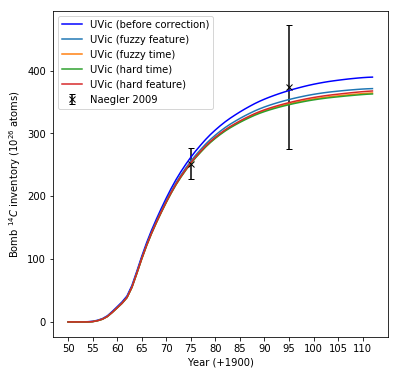

In [24]:
# Plot inventories
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(np.arange(50, 113), inv_f, 'b-', label="UVic (before correction)")
ax.plot(np.arange(50, 113), inv_f_ff, '-', label="UVic (fuzzy feature)")
ax.plot(np.arange(50, 113), inv_f_ft, '-', label="UVic (fuzzy time)")
ax.plot(np.arange(50, 113), inv_f_ht, '-', label="UVic (hard time)")
ax.plot(np.arange(50, 113), inv_f_hf, '-', label="UVic (hard feature)")
# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (+1900)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

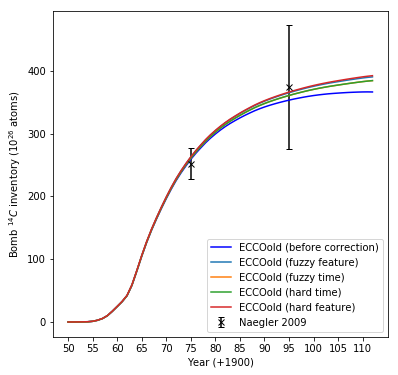

In [143]:
# Plot inventories
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(np.arange(50, 113), inv_f, 'b-', label="ECCOold (before correction)")
ax.plot(np.arange(50, 113), inv_f_ff, '-', label="ECCOold (fuzzy feature)")
ax.plot(np.arange(50, 113), inv_f_ft, '-', label="ECCOold (fuzzy time)")
ax.plot(np.arange(50, 113), inv_f_ht, '-', label="ECCOold (hard time)")
ax.plot(np.arange(50, 113), inv_f_hf, '-', label="ECCOold (hard feature)")
# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (+1900)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

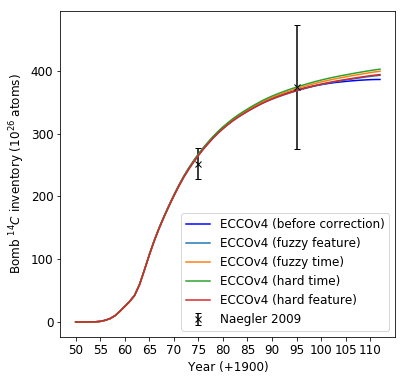

In [112]:
# Plot inventories
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(np.arange(50, 113), inv_f, 'b-', label="ECCOv4 (before correction)")
ax.plot(np.arange(50, 113), inv_f_ff, '-', label="ECCOv4 (fuzzy feature)")
ax.plot(np.arange(50, 113), inv_f_ft, '-', label="ECCOv4 (fuzzy time)")
ax.plot(np.arange(50, 113), inv_f_ht, '-', label="ECCOv4 (hard time)")
ax.plot(np.arange(50, 113), inv_f_hf, '-', label="ECCOv4 (hard feature)")
# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (+1900)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

## Plotting contour plots of fluxes vs latitude and year for each model
Similar to Figure 4 in *Graven et al. (2012)*, we sum up contributions of gross fluxes at each latitude band ($5^\circ$), across all longitudes and plot a contour plot using the CCSM fluxes.

In [ ]:
import os

def plot_flux(inp="net", mod=None):
    """
    Contour plots a CCSM flux (selected through inp) vs latitude bands of 5 deg and year.
    
    Input:
    ------
    inp : "net" - plots net flux
          "n14C" - plots net 14C flux, requires mod = "ECCO" or "CCSM"
          "as" - plots air-to-sea flux
          "sa" - plots sea-to-air flux
    """
    airseaf = file_ccsm_hist.variables['FG_CO2_abio_as'][:,:,:]
    seaairf = file_ccsm_hist.variables['FG_CO2_abio_sa'][:,:,:]
    if inp == "net":
        val = airseaf - seaairf
    elif inp == "n14C":
        if mod == "ECCO":
            net14C_flux_ec = np.ma.empty_like(file_ecco_hist[:,0,:,:])
            net14C_flux_ec[:,:,:] = 0

            for i in range(net14C_flux_ec.shape[0]):
                net14C_flux_ec[i,:,:] = np.loadtxt("Net_14C_flux_{0}_ECCO.csv".format(i+1960), delimiter=",")

            # Need to remask the array
            val = np.ma.array(net14C_flux_ec, mask=file_ecco_hist[:,0,:,:].mask)
        else: # assume CCSM
            # Read net 14C flux from txt files
            os.chdir("/home/kty115/msci/Model/CCSM/Net_14C_flux_CCSM/")

            net14C_flux = np.ma.empty_like(D14C_hist[:,0,:,:])

            for i in range(net14C_flux.shape[0]):
                net14C_flux[i,:,:] = np.loadtxt("Net_14C_flux_{0}.csv".format(i+1950), delimiter=",")

            # Need to remask the array
            val = np.ma.array(net14C_flux, mask=D14C_hist[:,0,:,:].mask)
    elif inp == "as":
        val = airseaf
    elif inp == "sa":
        val = seaairf
    
    # Locate contributions within each latitude band (+- 5 deg in lat, +- 0.5 deg in lon)
    if mod == "ECCO":
        

In [5]:
airseaf.shape

(63, 116, 100)